## Preenchendo dados faltantes

> Neste notebook apresentamos um algoritmo simples para preenchimento de "buracos" em séries temporais. Aqui nós consideramos buracos como regiões dentro da série que não possuem dados, ou possuem valores "*nan*" (not a number). Os valores zerados foram considerados com tendo sua significância semântica para o sistema (falta d'agua, por exemplo) e, portanto, não foram considerados como dados faltantes da série. A técnica utilizada de interpolação foi a linear.

**Long story short**: Buscamos na série os intervalos (s1, s2) faltantes ou com valores *nan*, geramos os índices para esses valores faltantes, preenchemos esses novos valores (entre s1 e s2) com uma interpolação linear, salvamos esta nova série. 


In [33]:
# Imports
%matplotlib inline
import pandas
import matplotlib.pyplot as plt
import datetime
import os
import glob
import random

import numpy as np

# Funções 

In [34]:

def get_label(score):
    
    if score < 0.10:
        return ('A', 'b')
    elif score >= 0.10 and score < 0.3: 
        return ('B','darkcyan')
    elif score >= 0.30 and score < 0.5: 
        return ('C', 'y')
    elif score >= 0.50 and score < 0.7:
        return ('D','lightcoral')
    else:
        return ('E','r')

def fill_missing_data(dataframe, granularity, method='nearest'):
    # column names
    columns = dataframe.keys()
    
    dates = dataframe[columns[0]]
    prev = dates[0]
    time = []
    data = []
    missing_data=0

    for index in range(1, len(dates)-1):
        diff = dates[index] - prev
        prev = dates[index]


        if not diff.total_seconds() == granularity:
            total_steps = diff.total_seconds()
            new_data = [[dates[index] - datetime.timedelta(seconds=x),np.nan] for x in range(int(granularity), int(total_steps),int(granularity))]
            
            # incrementando a quantidade de dados faltantes
            missing_data+= len(new_data)
            
            new_data.reverse()
            for item in new_data:
                time.append(item[0])
                data.append(item[1])

        time.append(prev)
        data.append(dataframe[columns[1]][index])
    
    # calcular score da serie
    score = missing_data/len(data)
    print(score)
    label = get_label(score)
    
    columns = ['time', 'data']
    newDataframe = pandas.DataFrame(columns=columns)
    
    newDataframe.time = time
    newDataframe.data = data
    
    newDataframe.set_index('time')
    newDataframe.sort_values(by='time')
    newDataframe = newDataframe.interpolate(method=method)
    
    return newDataframe, label


def get_granularity(dataframe):
    # column names
    columns = dataframe.keys()
    
    dates = dataframe[columns[0]]
    prev = dates[0]
    diffs_counter=dict()

    for index in range(1, len(dates)-1):
        diff = dates[index] - prev
        prev = dates[index]

        if diff.total_seconds() not in diffs_counter.keys():
            diffs_counter[diff.total_seconds()]=1
        else:
            diffs_counter[diff.total_seconds()]+=1
    
    common_diff = list(diffs_counter)[(np.argmax(diffs_counter))]
    
    return common_diff
    


def smooth(x, window_len=10, window='hanning'):    
    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if window_len < 3:
        return x

    s=np.r_[2*x[0]-x[window_len:1:-1], x, 2*x[-1]-x[-1:-window_len:-1]]
    #print(len(s))

    if window == 'flat': #moving average
        w = np.ones(window_len,'d')
    else:
        w = getattr(np, window)(window_len)
    y = np.convolve(w/w.sum(), s, mode='same')
    return y[window_len-1:-window_len+1]


In [3]:
output_csv = 'filteredDataframe.csv' 

# loading dataset
dataframe = pandas.read_csv('../dados/00010391_GLE_CABIL_2P1F_FLOW.csv', engine='python', header=0)
dataframe.head()

dateTime   data
0  2018-01-01 00:15:00  3.944
1  2018-01-01 00:30:00  3.722
2  2018-01-01 00:45:00  4.194
3  2018-01-01 01:00:00  4.000
4  2018-01-01 01:15:00  3.250

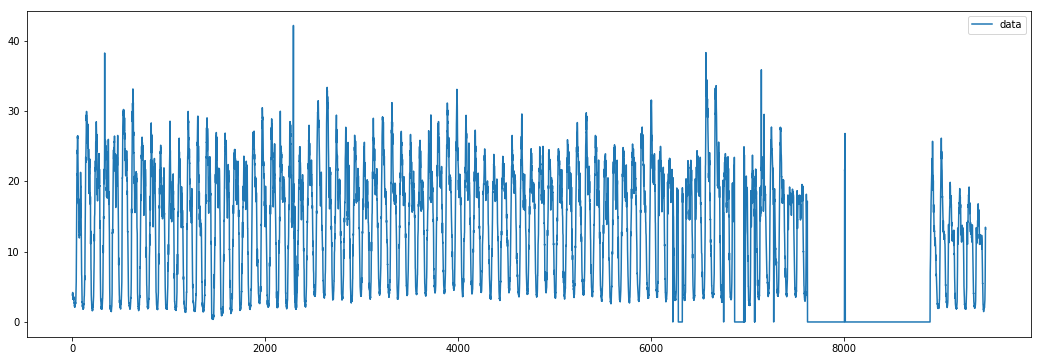

In [4]:
dataframe.plot(figsize=(18,6))

0.4497763318422123


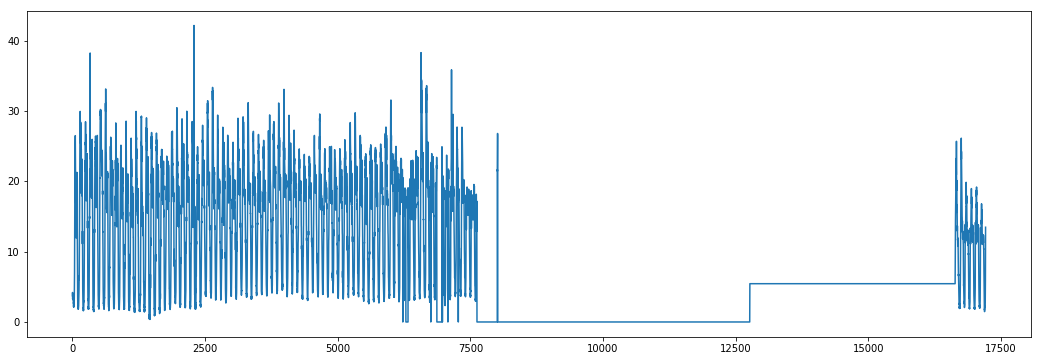

In [19]:
# column names
columns = dataframe.keys()

# converting to datetime
dataframe[columns[0]]= pandas.to_datetime(dataframe[columns[0]])

granularity     = get_granularity(dataframe)
preprocessed_df,label = fill_missing_data(dataframe, granularity)

plt.figure(figsize=(18,6))
plt.plot(preprocessed_df.data.values)
plt.show()
# saving the new dataset
#preprocessed_df.to_csv(output_csv)

# Extendendo para todas as series

 Aqui nós aplicamos a técnica de preenchimento de buracos para todas as séries existentes. 
 
 > Obs.: Só execute esta célula 1x, pois os resultados são salvos em um novo arquivo .csv com a série transformada

In [4]:
basefolder = '../dados/'
data = glob.glob(basefolder + '*.csv')

for filename in data:
    print("processando : ", filename)
    outputname = os.path.basename(filename) + '_filtered.csv'
    
    # loading dataset
    dataframe = pandas.read_csv(filename, engine='python', header=0)
    
    # column names
    columns = dataframe.keys()

    # converting to datetime
    dataframe[columns[0]] = pandas.to_datetime(dataframe[columns[0]])

    granularity     = get_granularity(dataframe)
    preprocessed_df, score = fill_missing_data(dataframe, granularity)

    # salvando o resultado em um novo csv
    preprocessed_df.to_csv(outputname)
    

# Antes x depois

Após realizar a interpolação linear para cobrir os "buracos" nas séries, vamos analisar o efeito desse completamento observando a série original e após realizar o preenchimento. Note que os buracos não aparecem na série original, pois são datas que não estão nas medições, mas deveriam estar, seguindo a ordem cronológica.

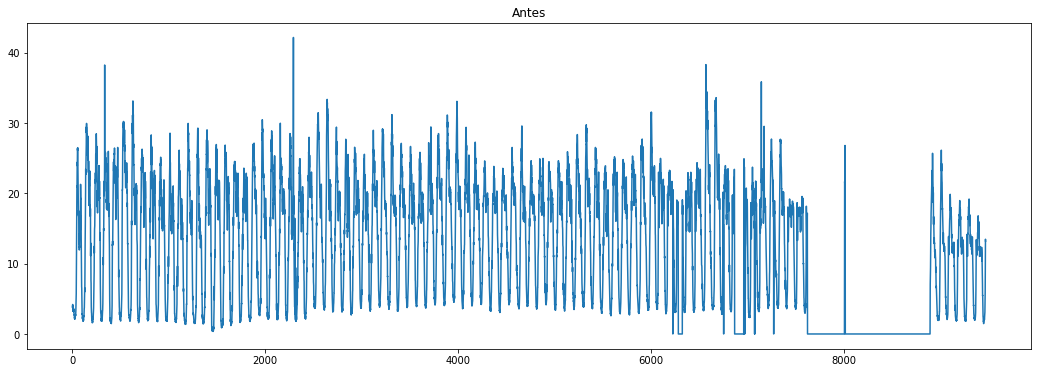

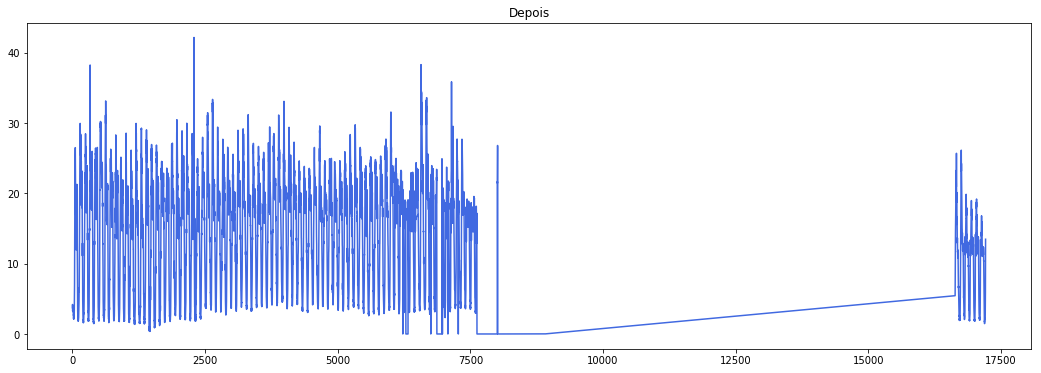

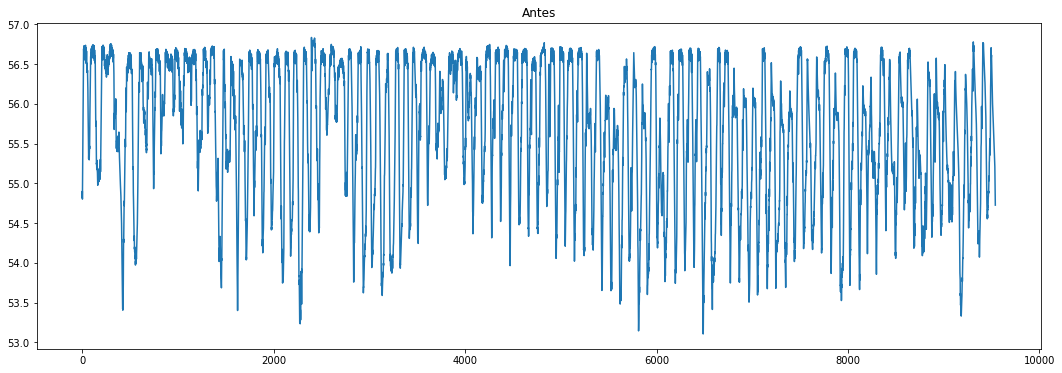

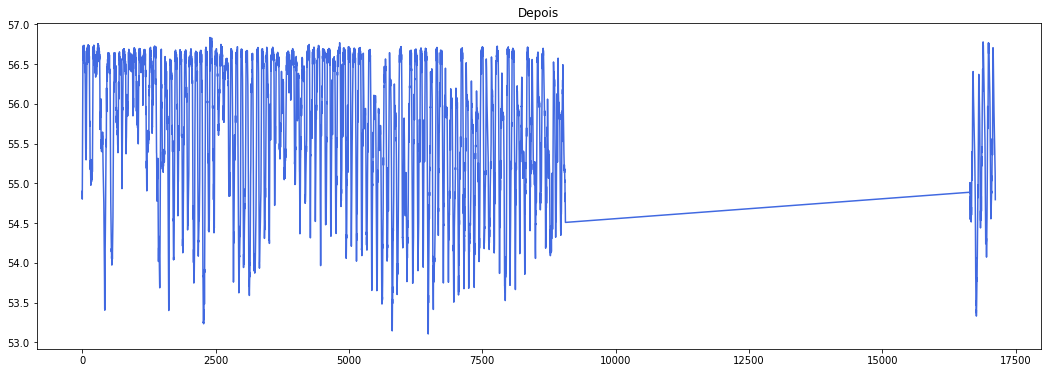

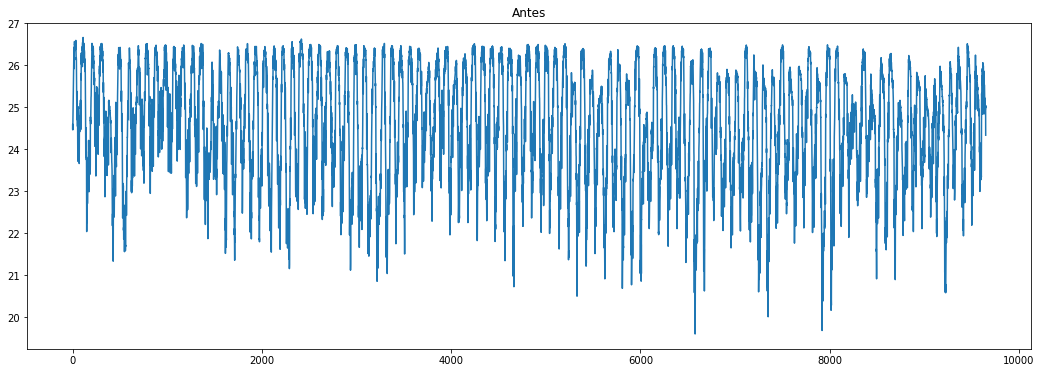

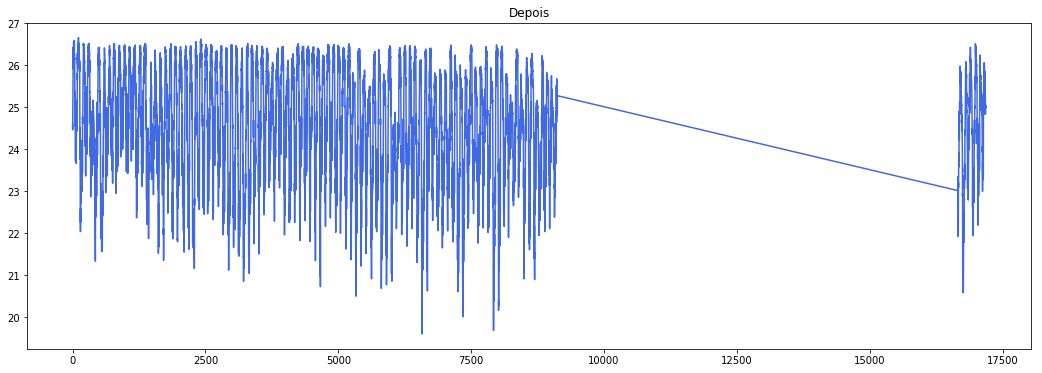

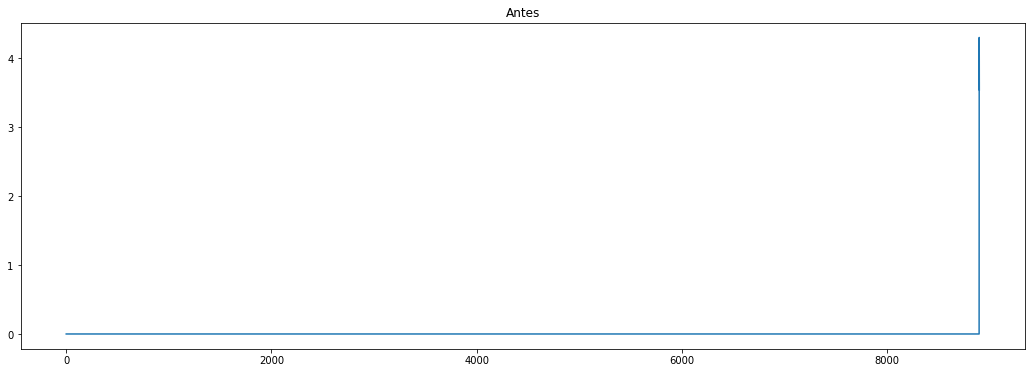

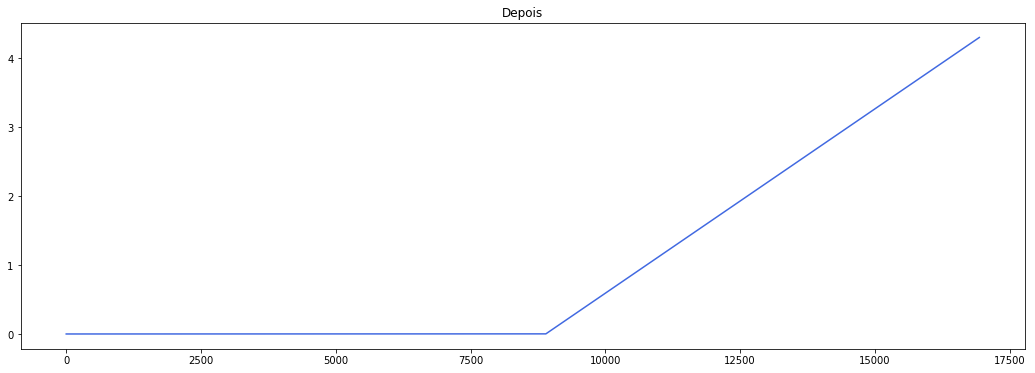

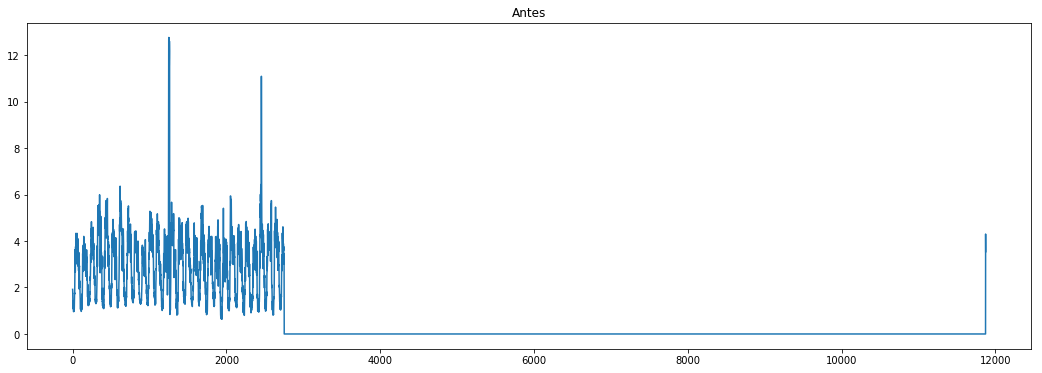

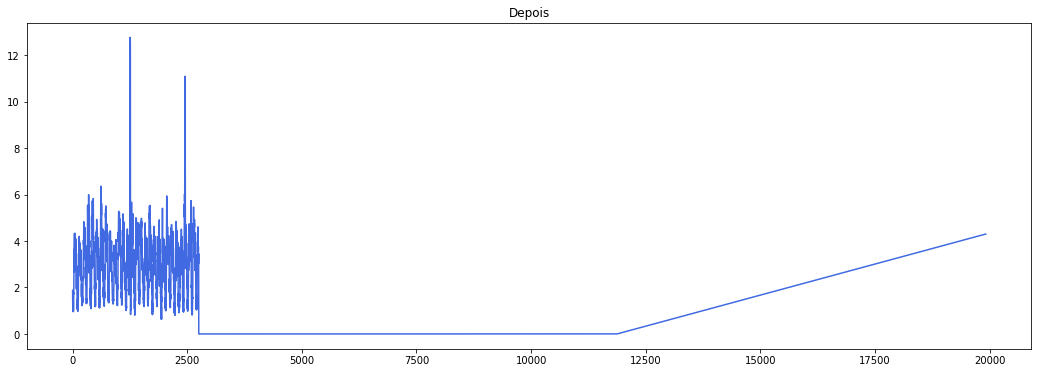

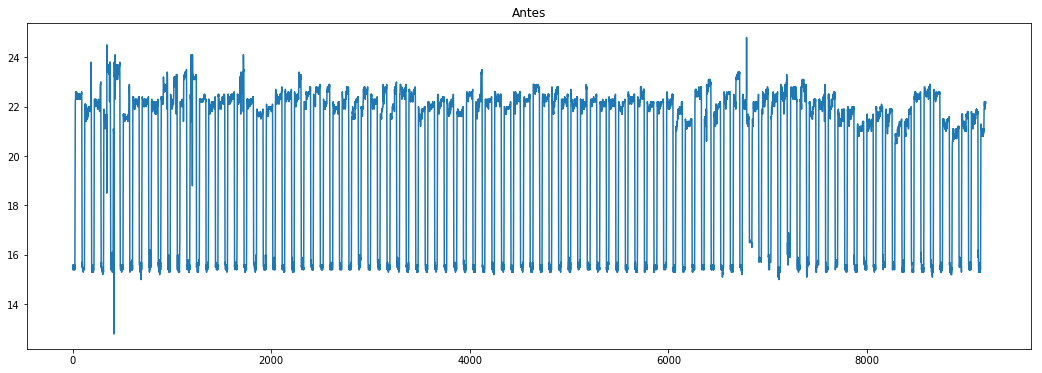

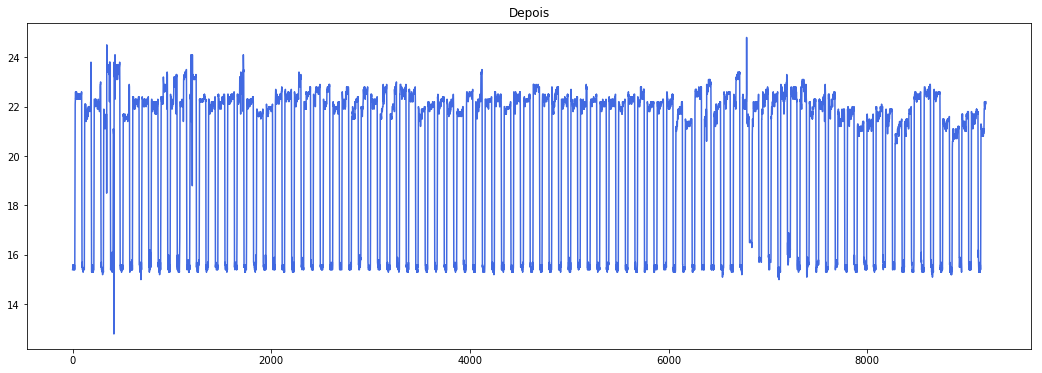

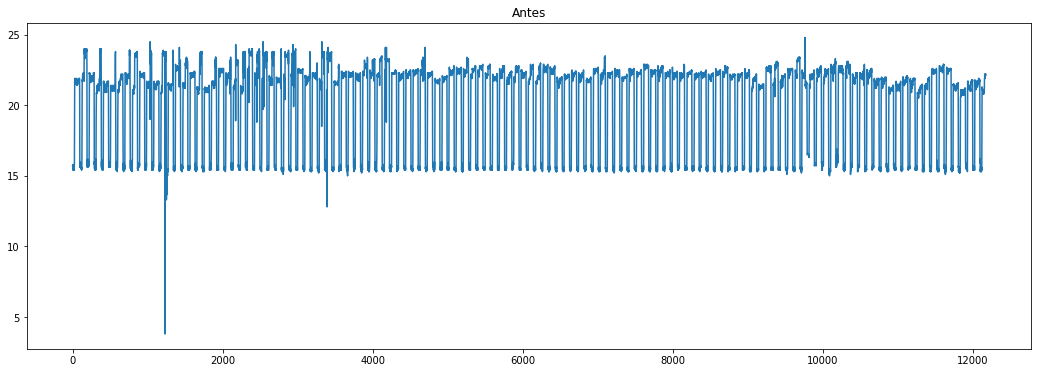

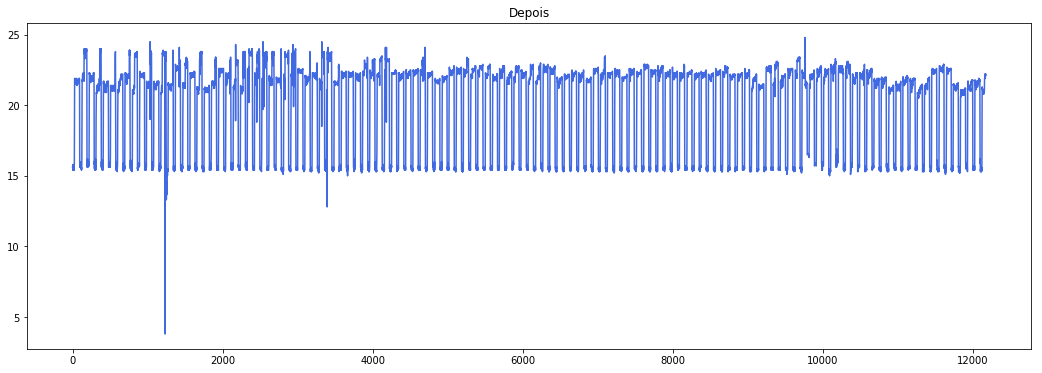

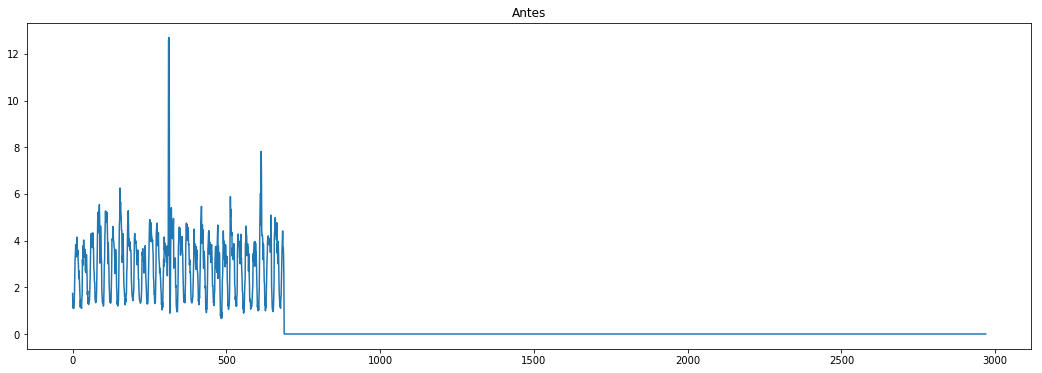

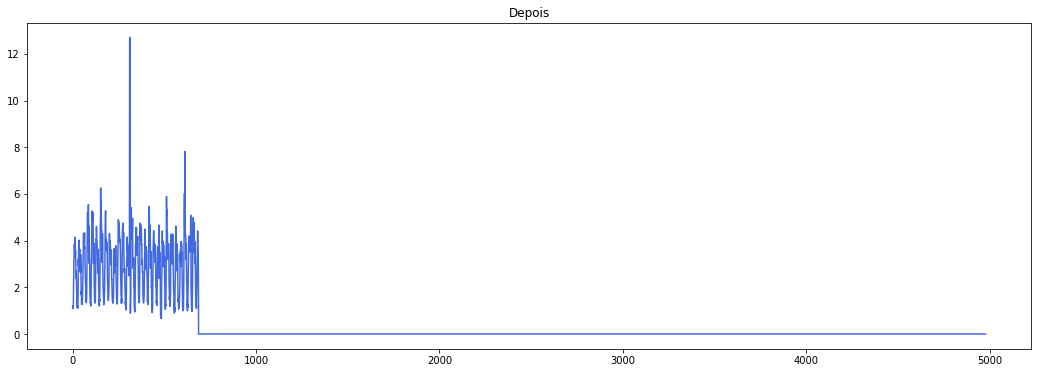

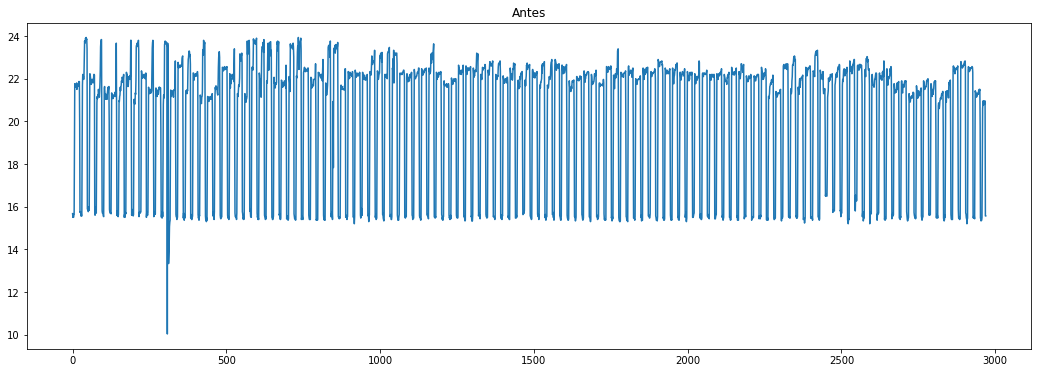

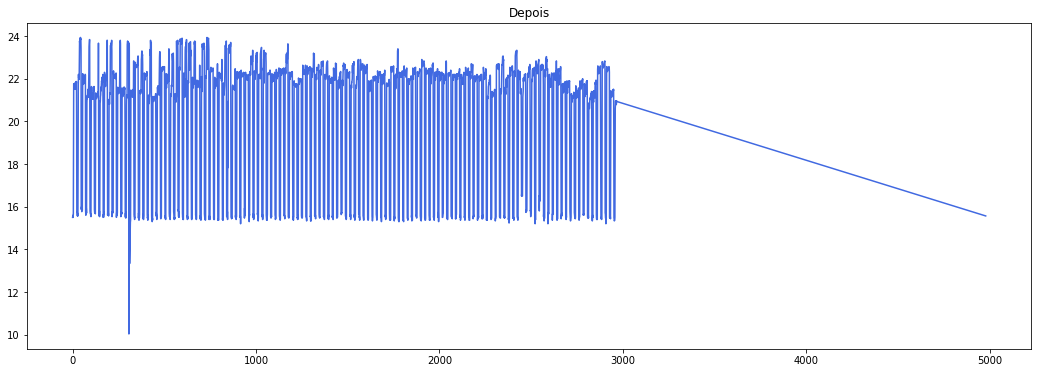

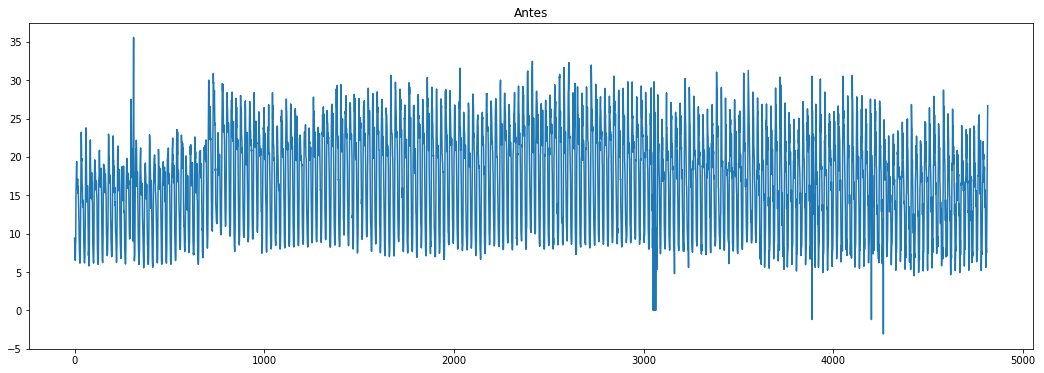

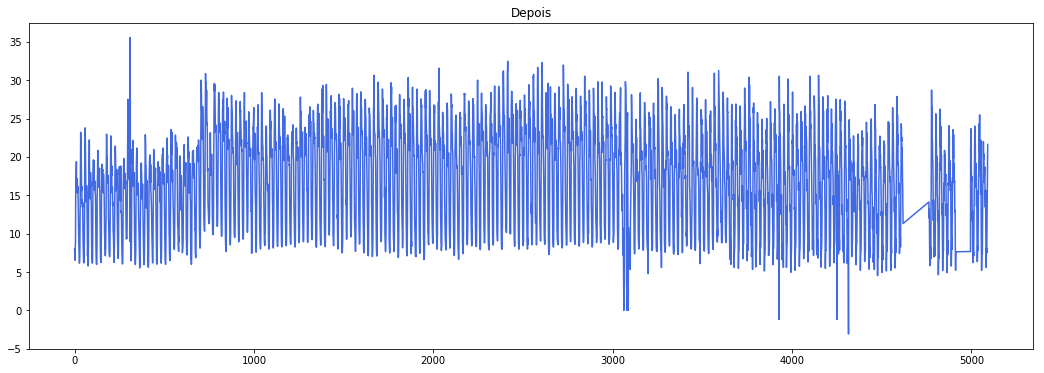

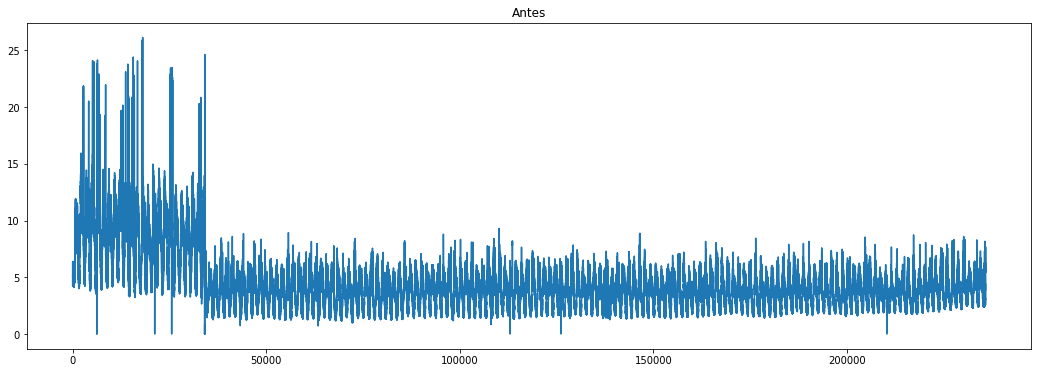

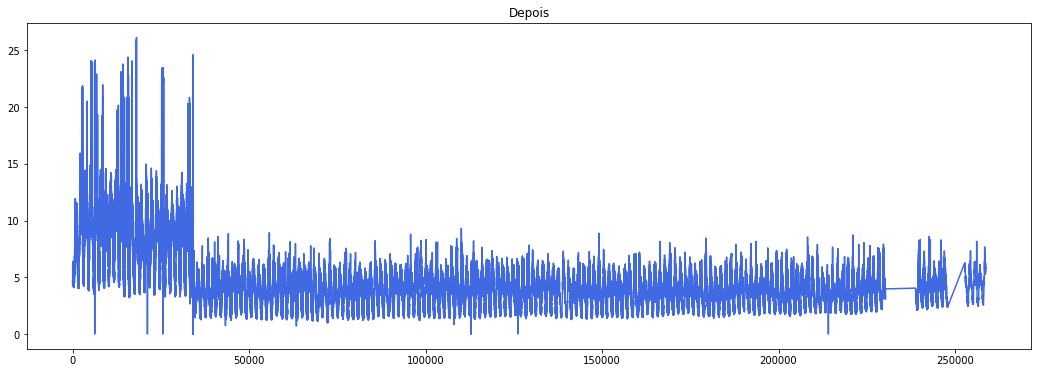

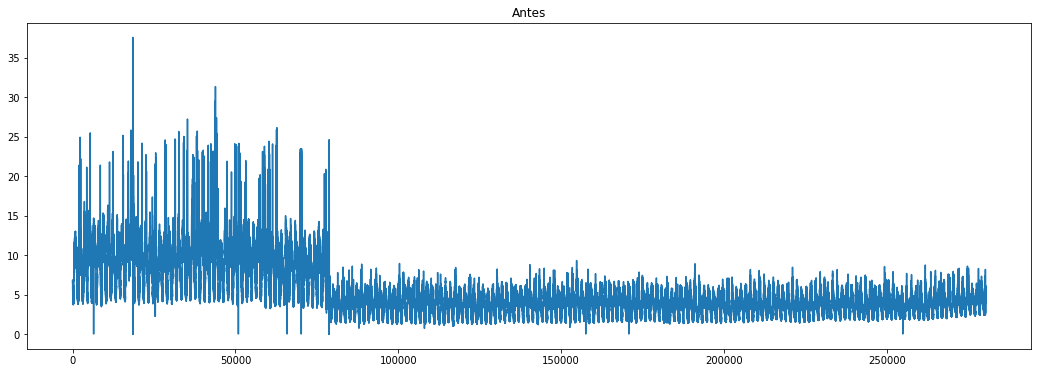

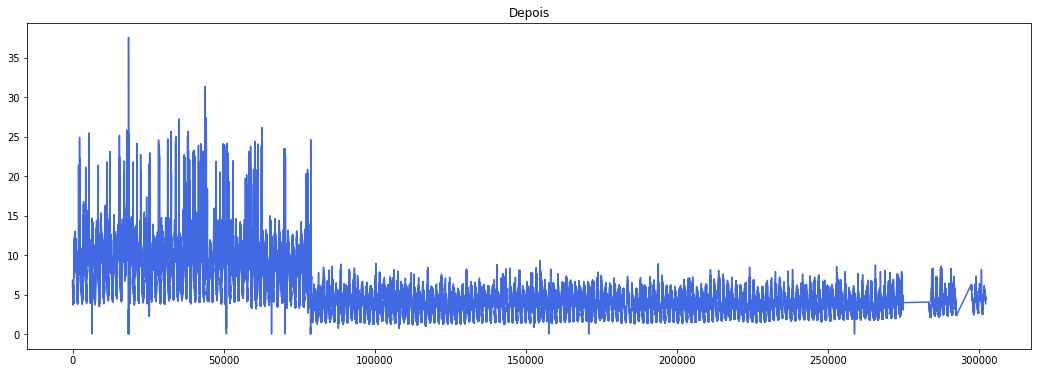

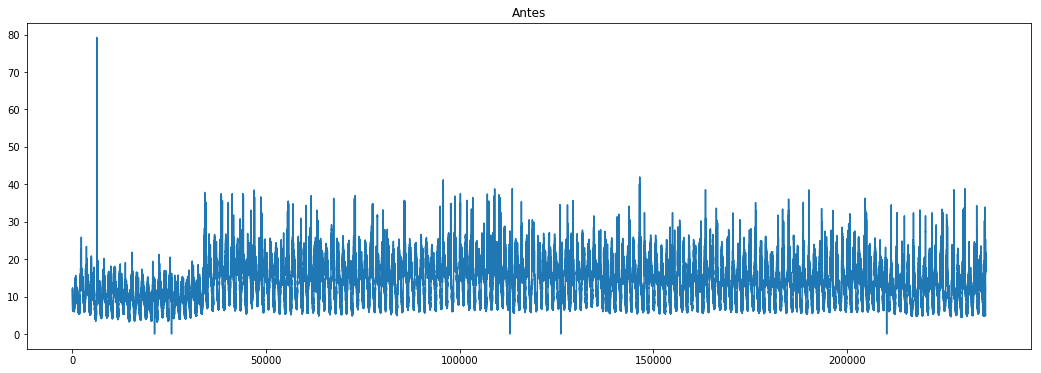

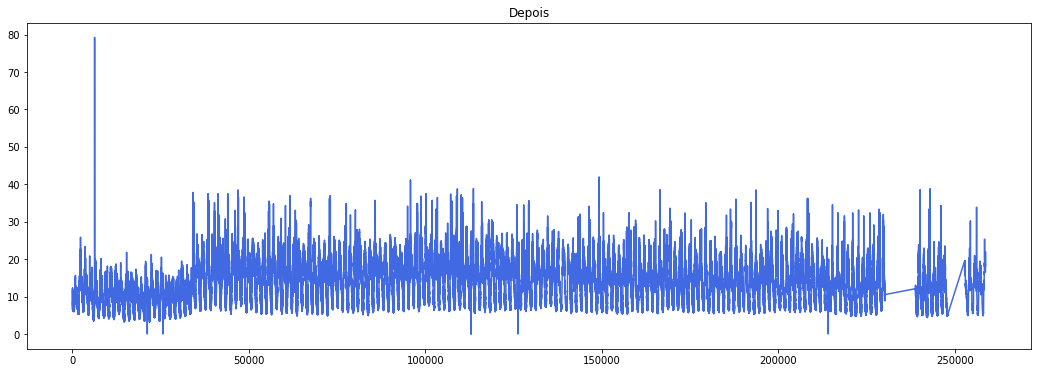

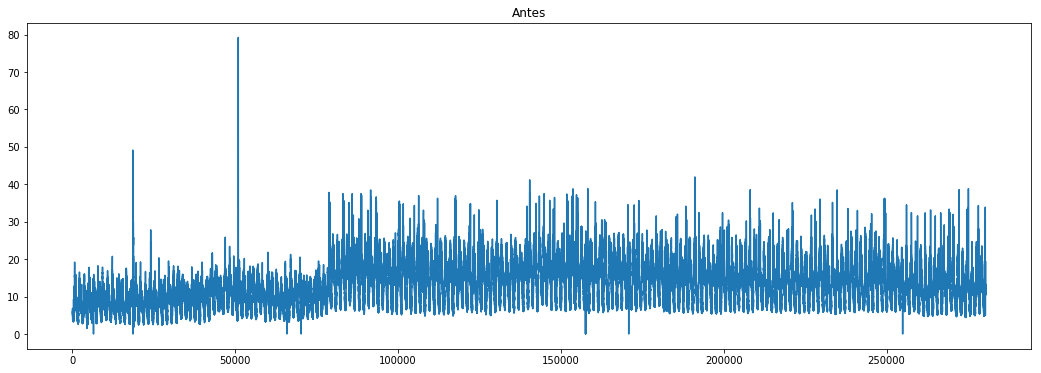

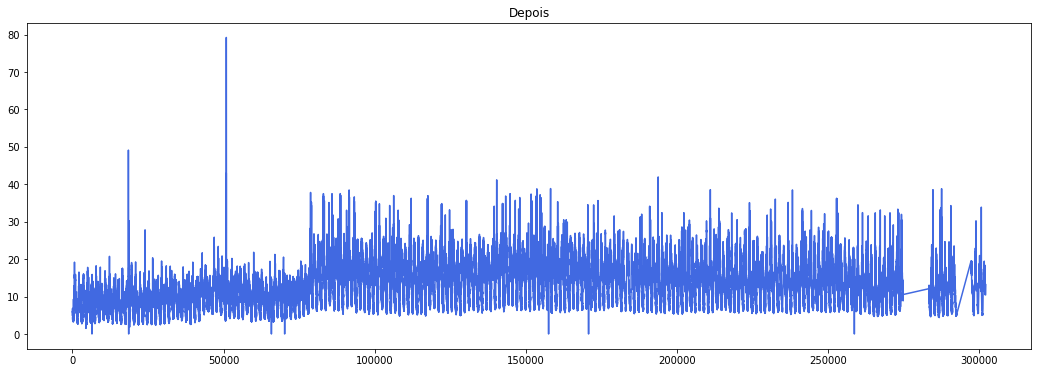

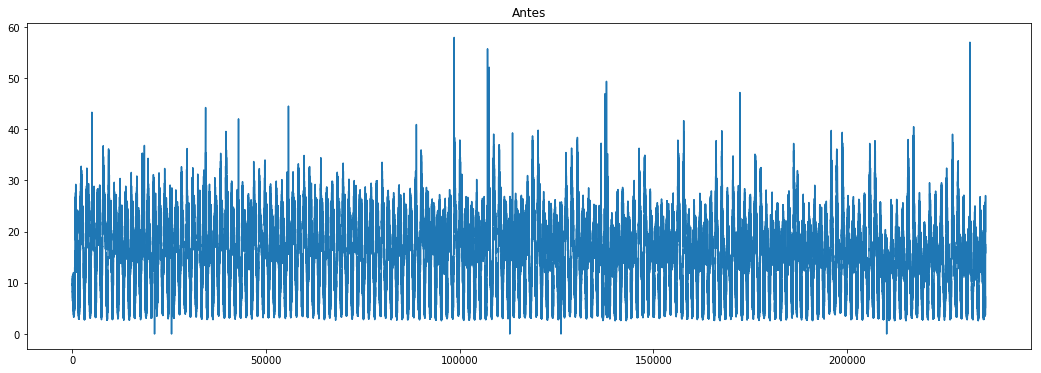

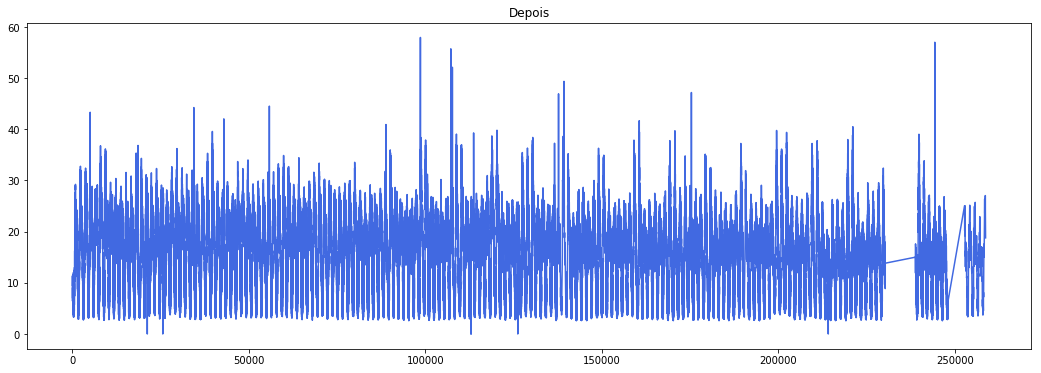

In [22]:
basefolder = '../dados/'
data = glob.glob(basefolder + '*.csv')

for filename in data:
    # original
    original_df = pandas.read_csv(filename, engine='python', header=0)
    plt.figure(figsize=(18,6))
    plt.title('Antes')
    plt.plot(original_df.data.values)
    
    # serie com dados faltantes completados
    filename = os.path.basename(filename) + '_filtered.csv'

    df = pandas.read_csv(filename, engine='python', header=0)
    plt.figure(figsize=(18,6))
    plt.title('Depois')
    plt.plot(df.data.values, color='royalblue')
    
    plt.show()
    

# Suavização das series

 Aqui nós selecionamos os realizamos a suavização das séries através
 de uma convolução 1d. O resultados, para melhor visualização, são 
 apresentados nos primeiros 500 pontos iniciais de cada série.

processando :  ../dados/00010391_GLE_CABIL_2P1F_FLOW.csv


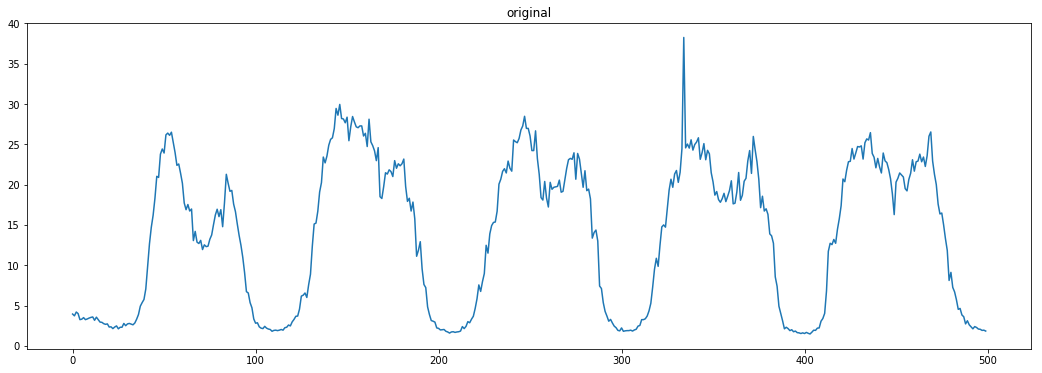

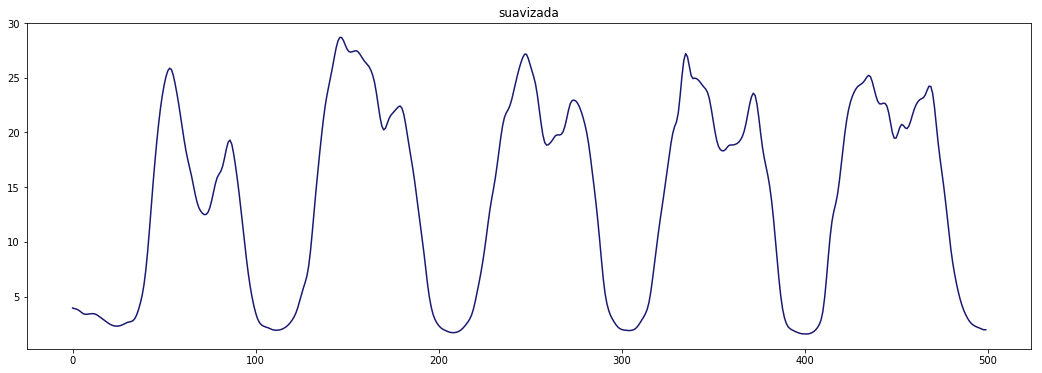

processando :  ../dados/101981_GLE_CABIL_1P0F_EXP_PRES_C3.csv


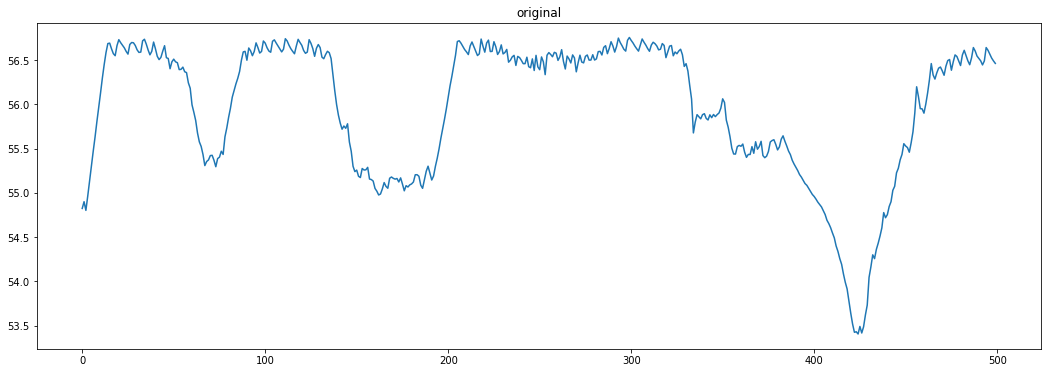

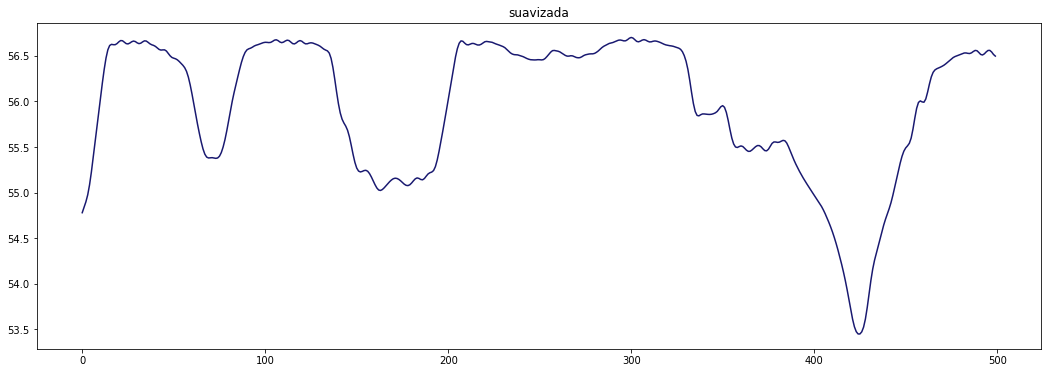

processando :  ../dados/102048_GLE_CABIL_1P0F_EXP_PRES_C3.csv


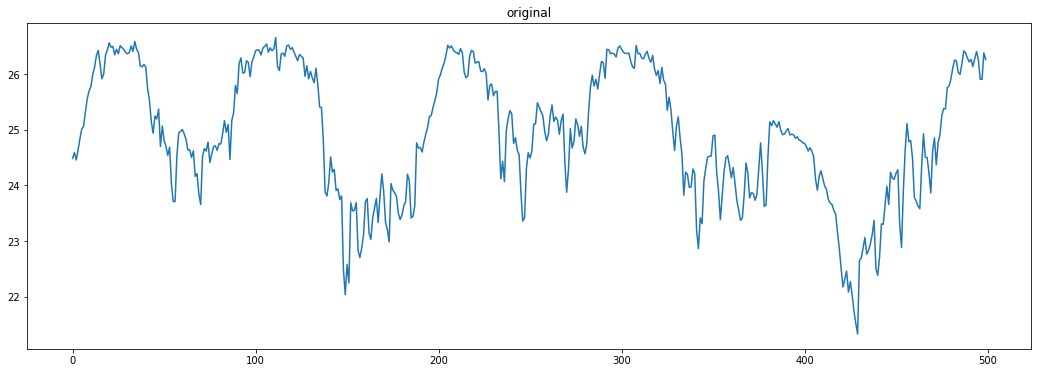

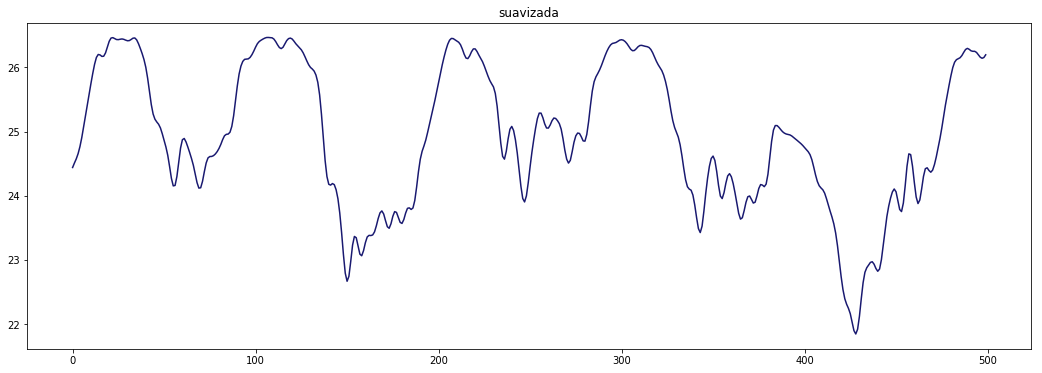

processando :  ../dados/41222_DNK_CABIL_CTRLB_FLOW (1).csv


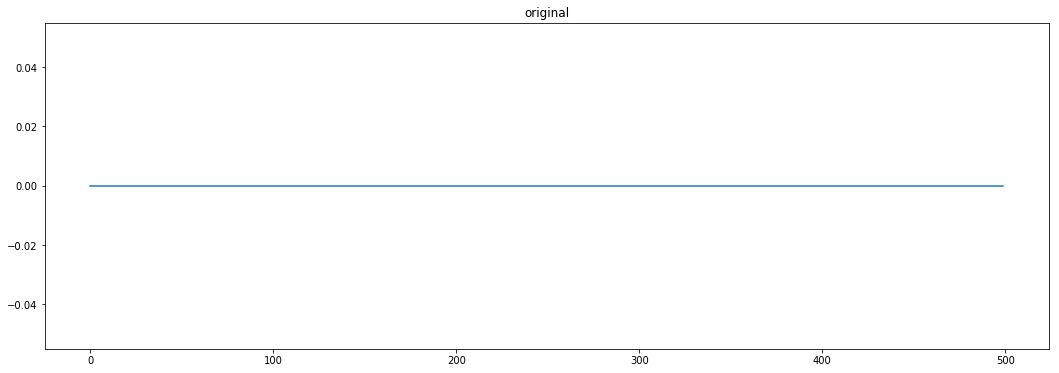

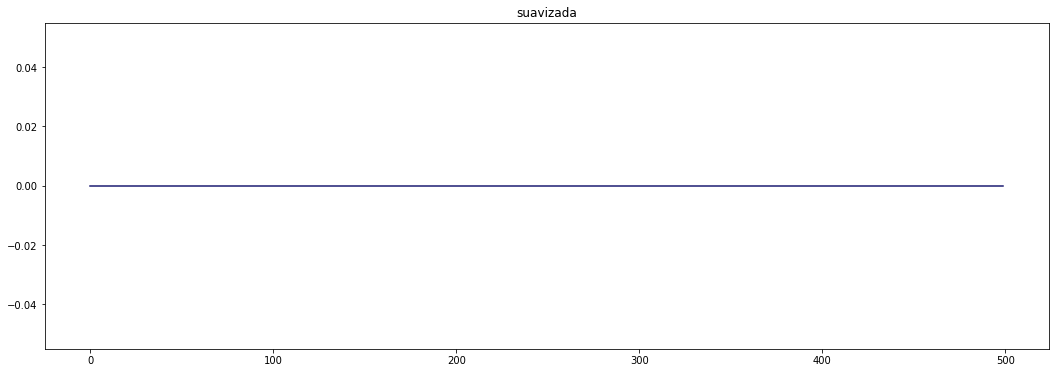

processando :  ../dados/41222_DNK_CABIL_CTRLB_FLOW.csv


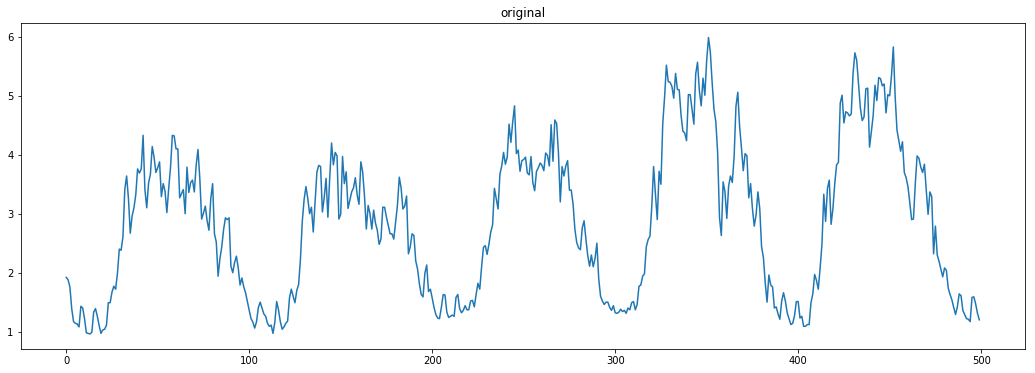

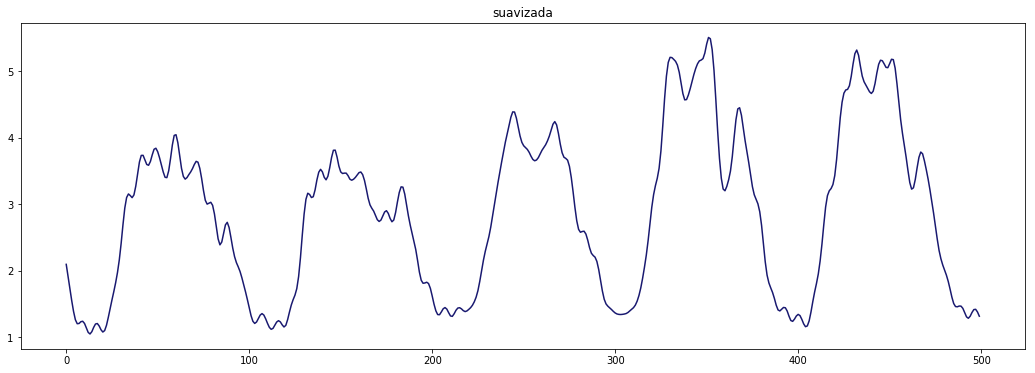

processando :  ../dados/7397_DNK_CABIL_PCRIP_PRES_C3 (1).csv


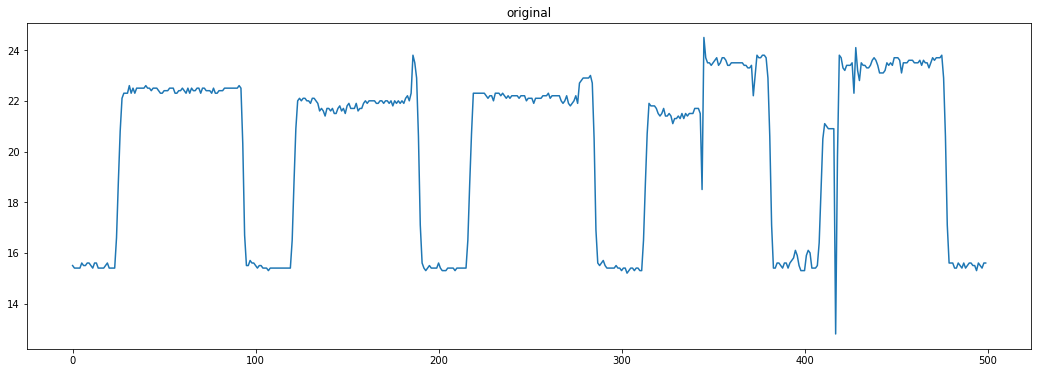

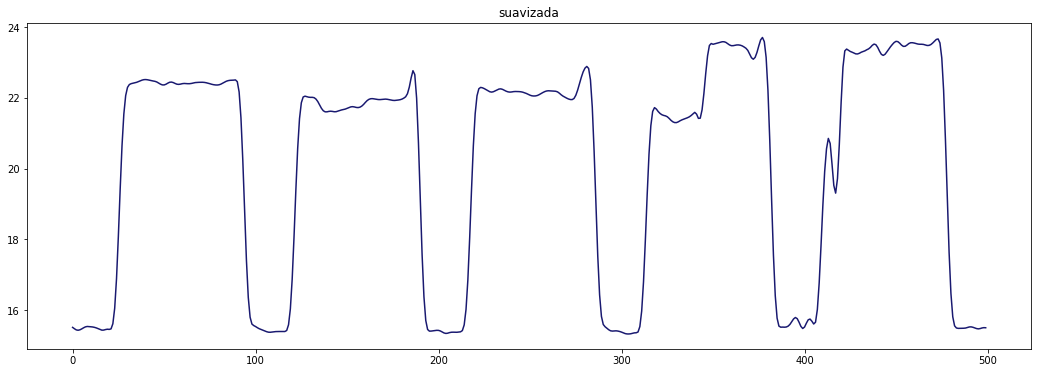

processando :  ../dados/7397_DNK_CABIL_PCRIP_PRES_C3.csv


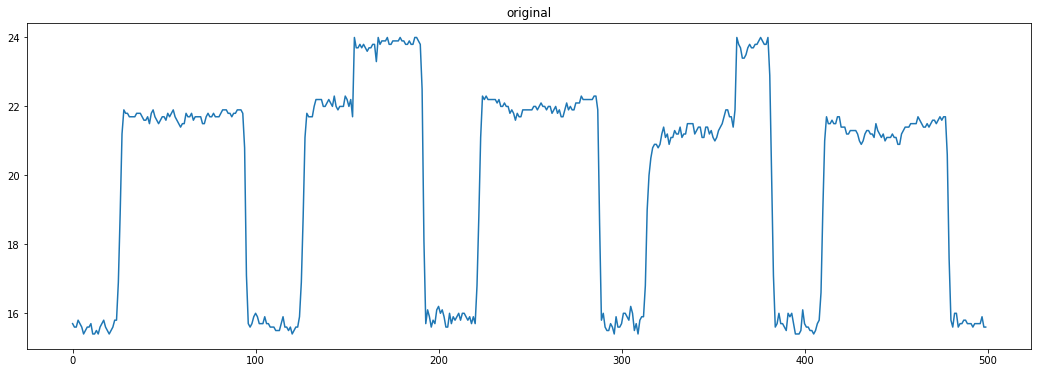

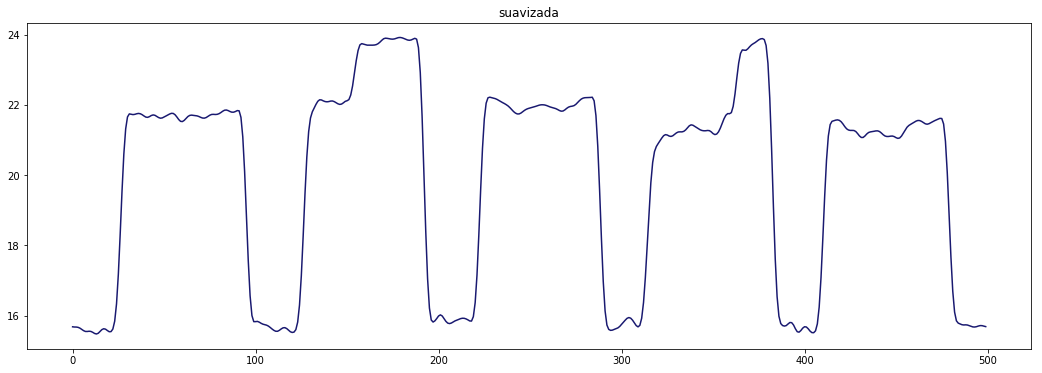

processando :  ../dados/dma1.1_flow.csv


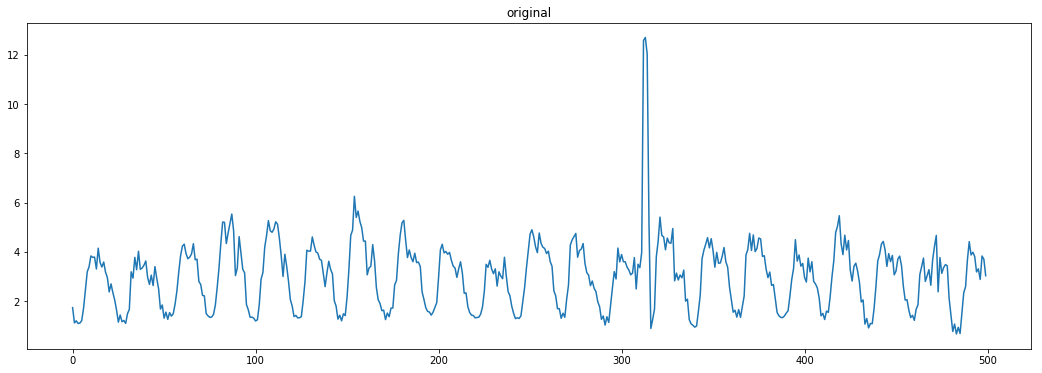

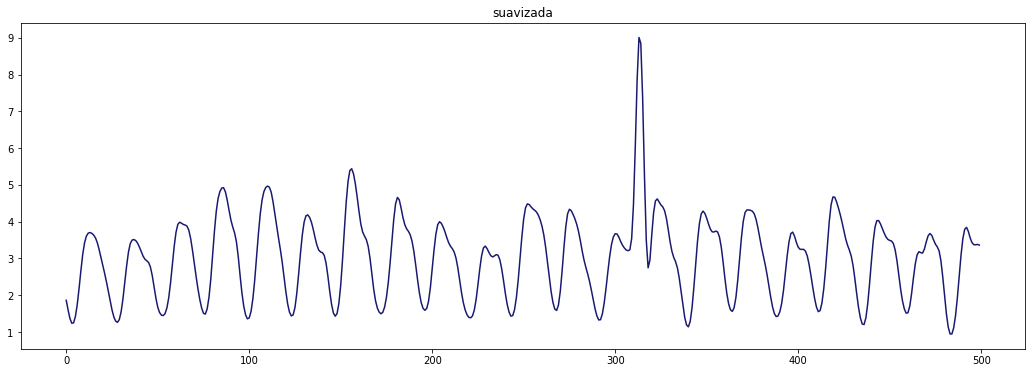

processando :  ../dados/dma1.1_pressure.csv


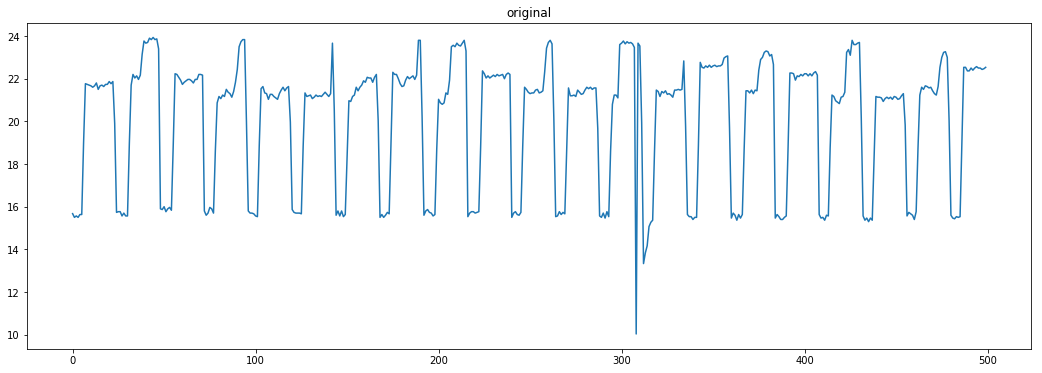

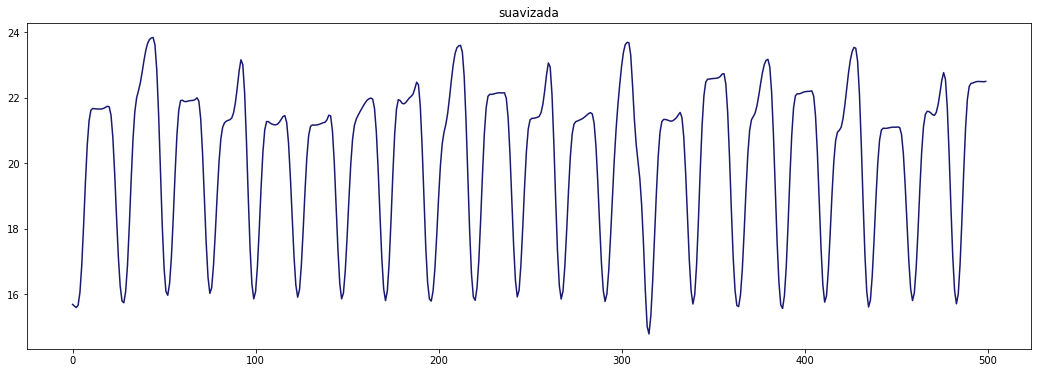

processando :  ../dados/dma1_flow.csv


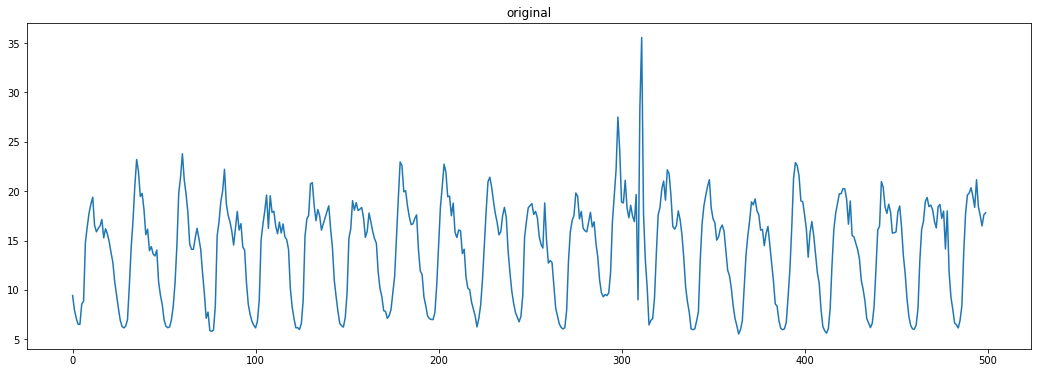

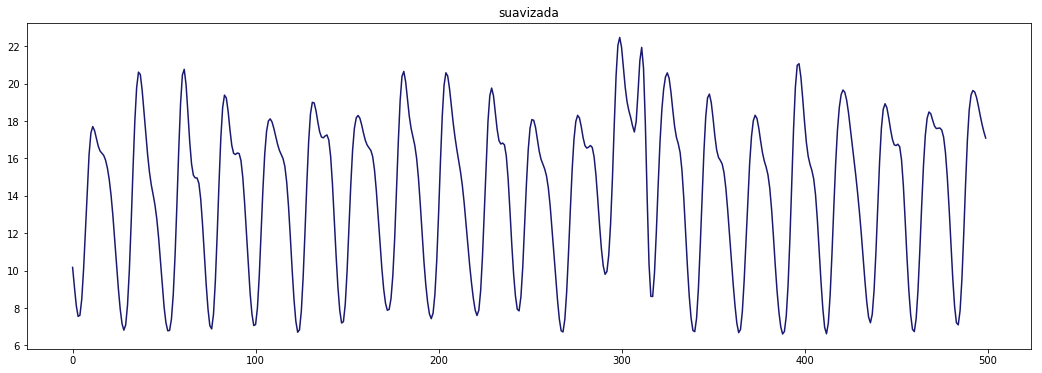

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC02.F_CV copy.csv


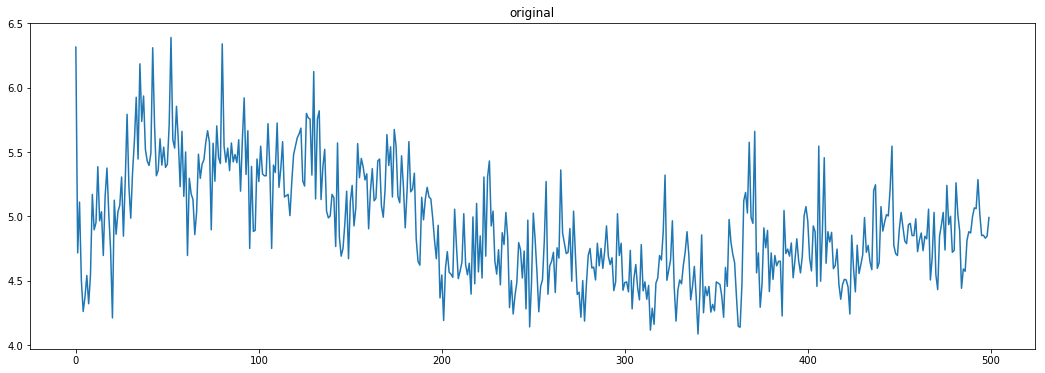

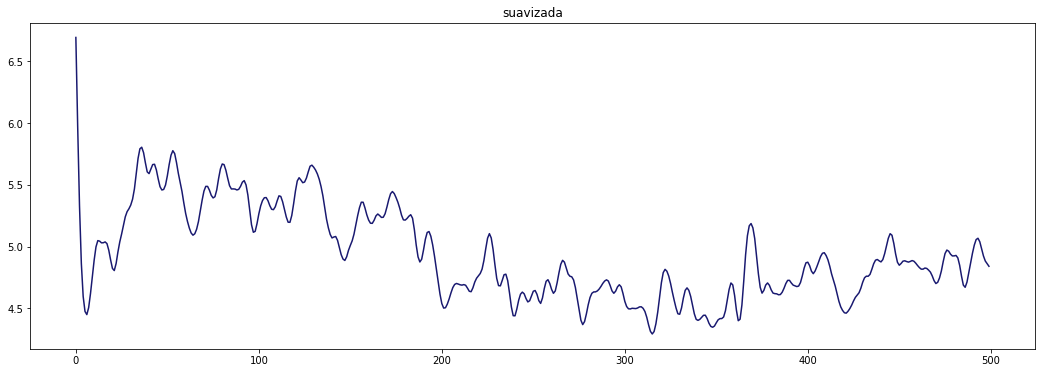

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC02.F_CV.csv


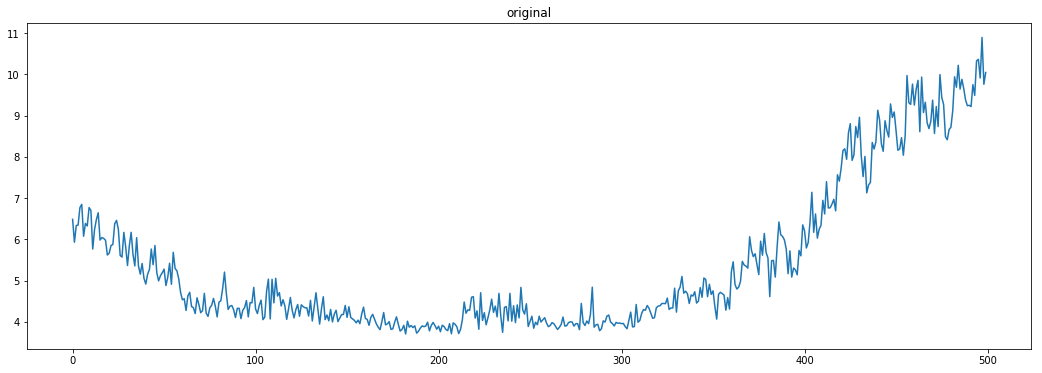

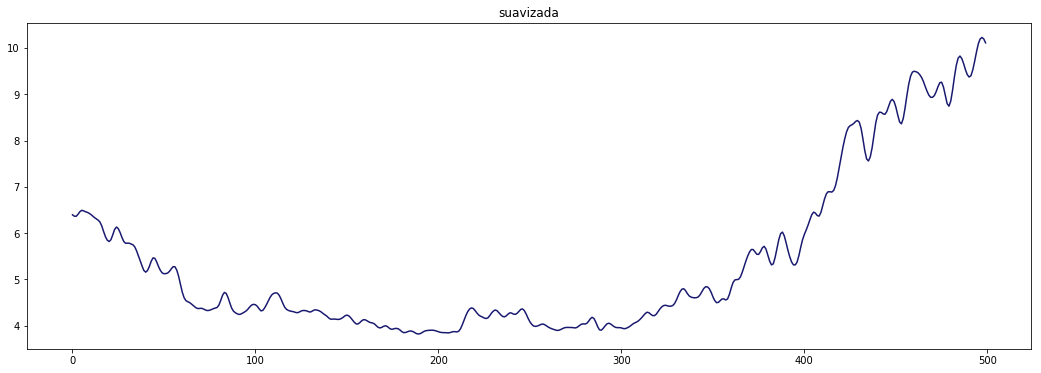

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC03.F_CV copy.csv


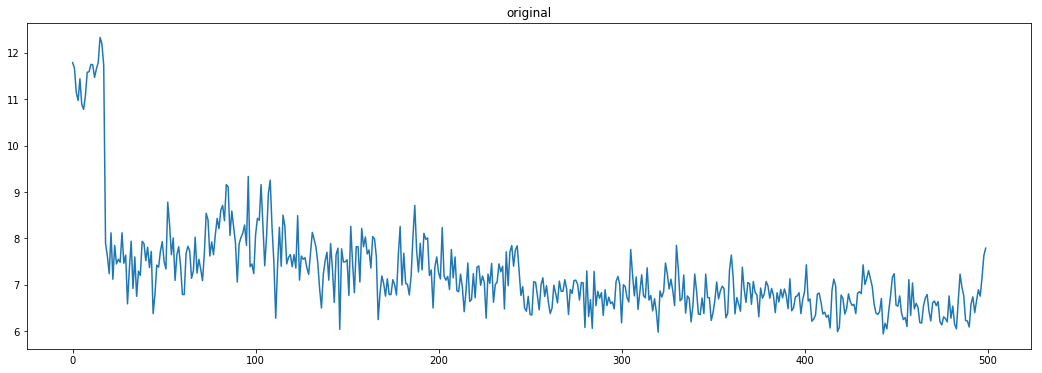

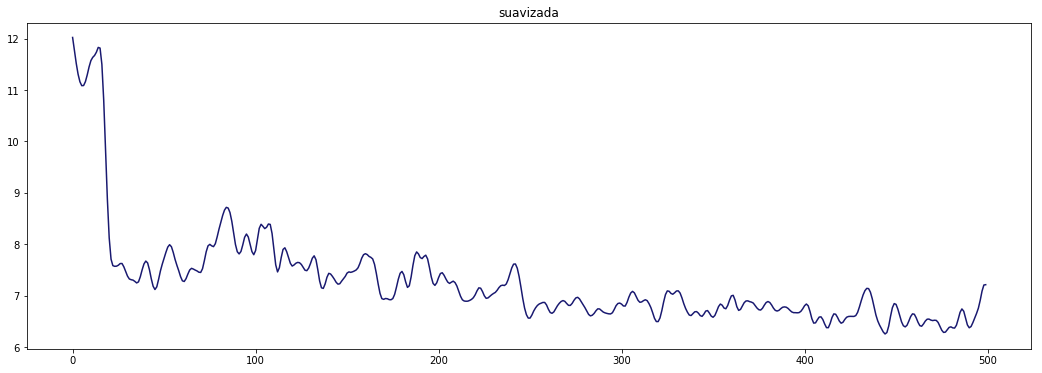

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC03.F_CV.csv


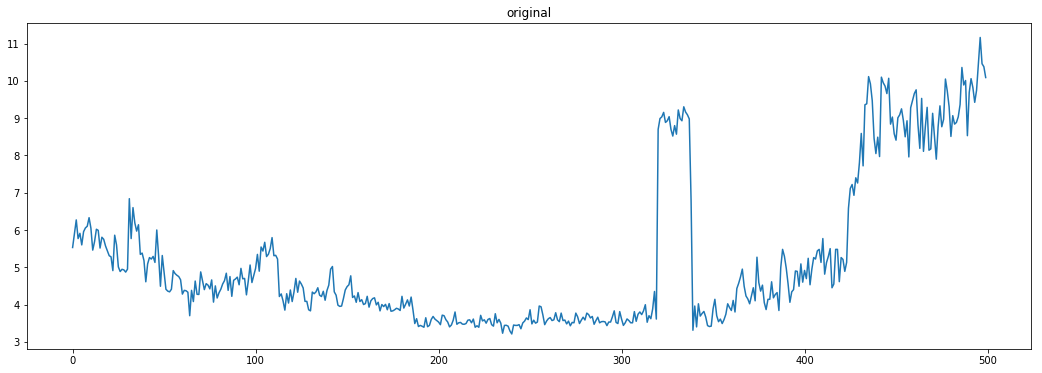

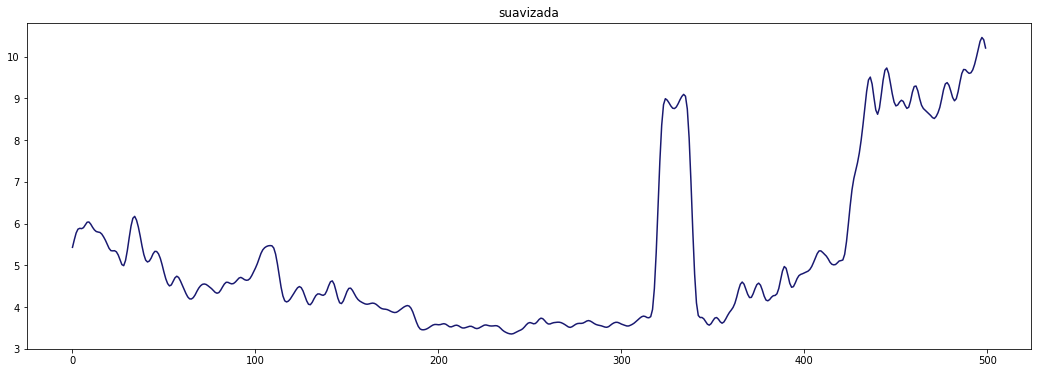

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC05.F_CV.csv


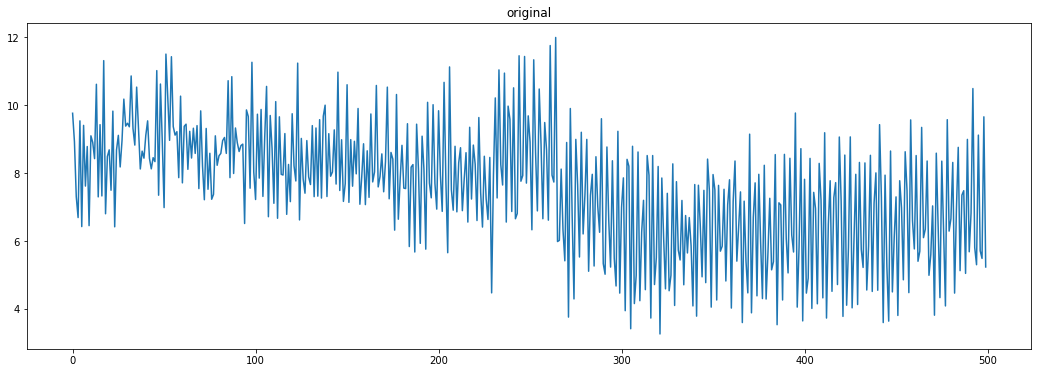

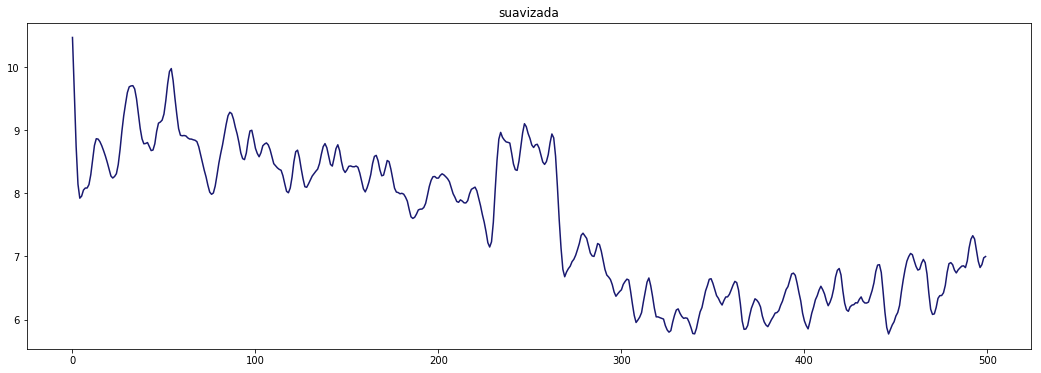

In [24]:
basefolder = '../dados/'
data = glob.glob(basefolder + '*.csv')

for filename in data:
    print("processando : ", filename)
    
    # loading dataset
    dataframe   = pandas.read_csv(filename, engine='python', header=0)
    dataframe.iloc[:500,1].plot(title='original',figsize=(18,6))
    plt.show()
    keys = dataframe.keys()
    
    data_values = dataframe[keys[1]].values
    smooth_data = smooth(data_values,window_len=10)
    
    plt.figure(figsize=(18,6))
    plt.title("suavizada")
    plt.plot(smooth_data[:500], color='midnightblue' )
    plt.show()

    
    

# Visualizando as séries com seu label

Este label é calculado baseado na quantidade de dados faltantes na serie

processando :  ../dados/00010391_GLE_CABIL_2P1F_FLOW.csv
0.4497763318422123


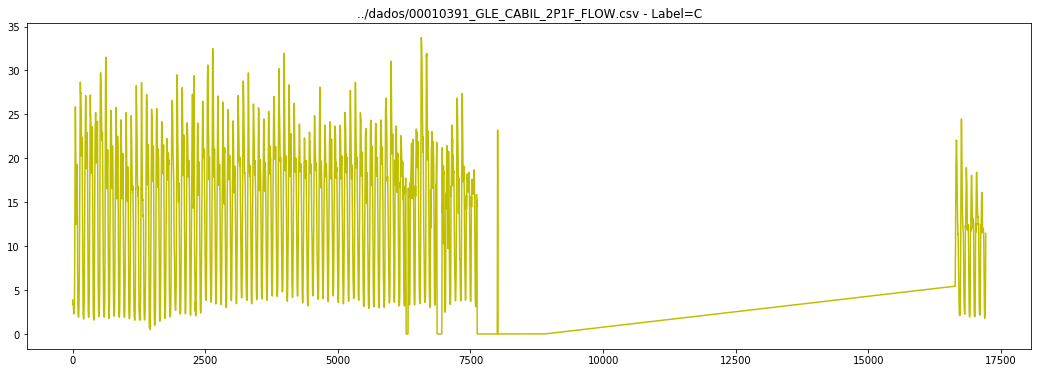

processando :  ../dados/101981_GLE_CABIL_1P0F_EXP_PRES_C3.csv
0.4428087393387078


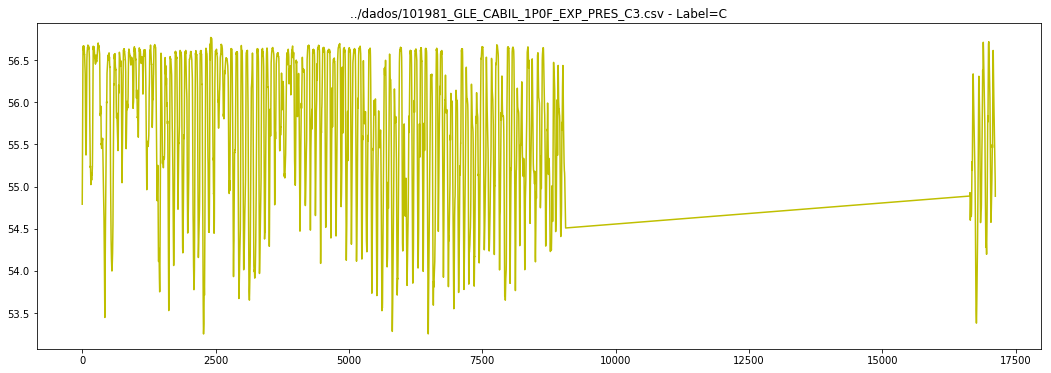

processando :  ../dados/102048_GLE_CABIL_1P0F_EXP_PRES_C3.csv
0.43842393202188334


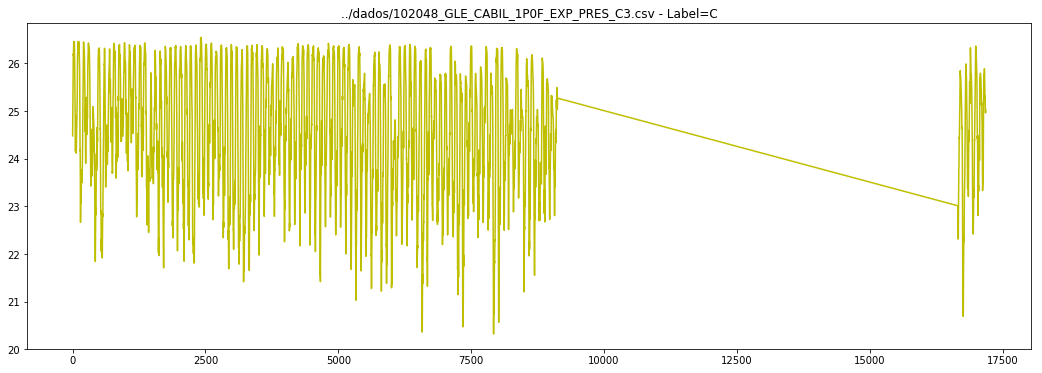

processando :  ../dados/41222_DNK_CABIL_CTRLB_FLOW (1).csv
0.47479338842975205


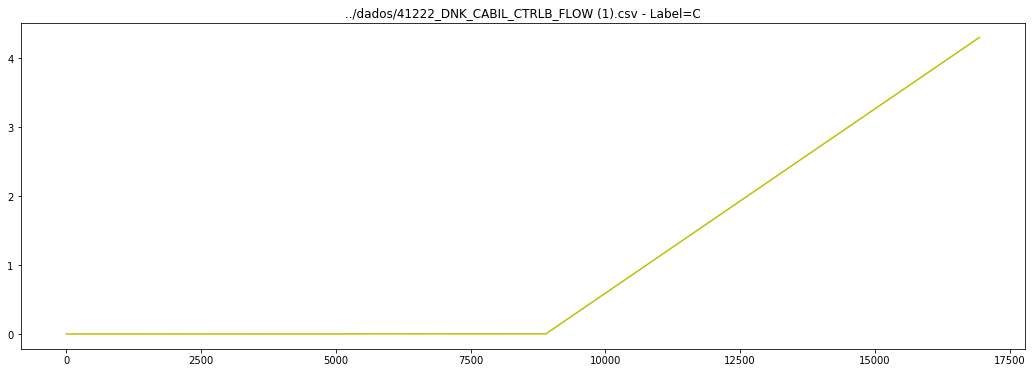

processando :  ../dados/41222_DNK_CABIL_CTRLB_FLOW.csv
0.4038760857558869


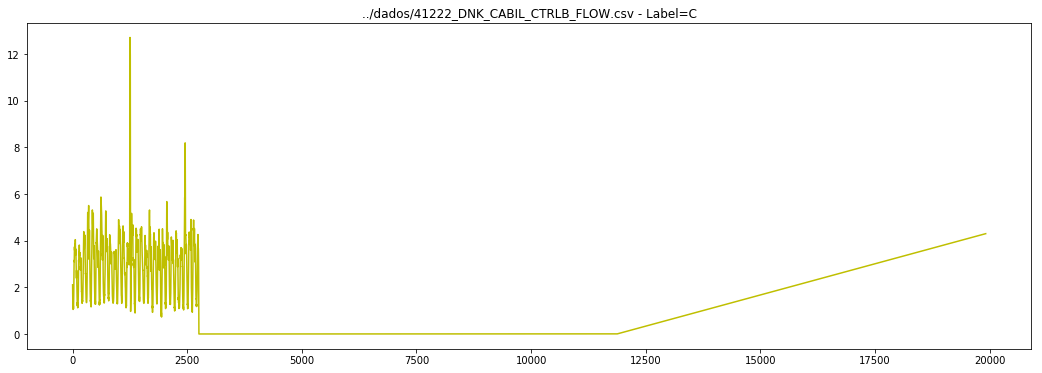

processando :  ../dados/7397_DNK_CABIL_PCRIP_PRES_C3 (1).csv
0.0


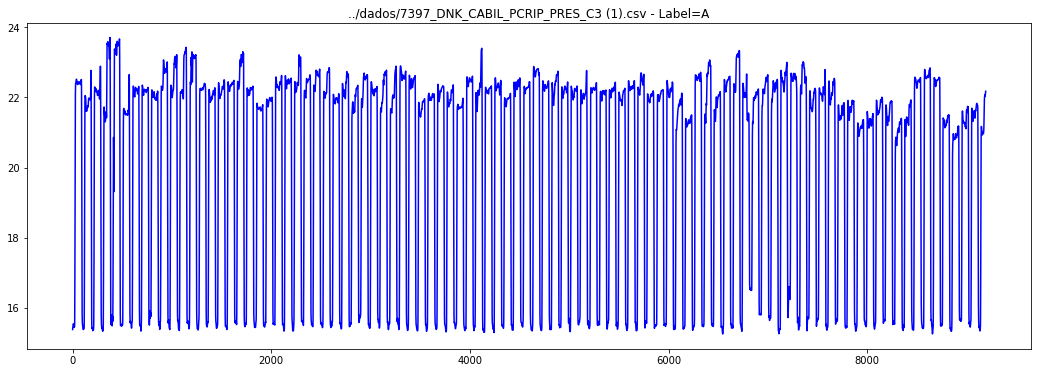

processando :  ../dados/7397_DNK_CABIL_PCRIP_PRES_C3.csv
8.216251745953496e-05


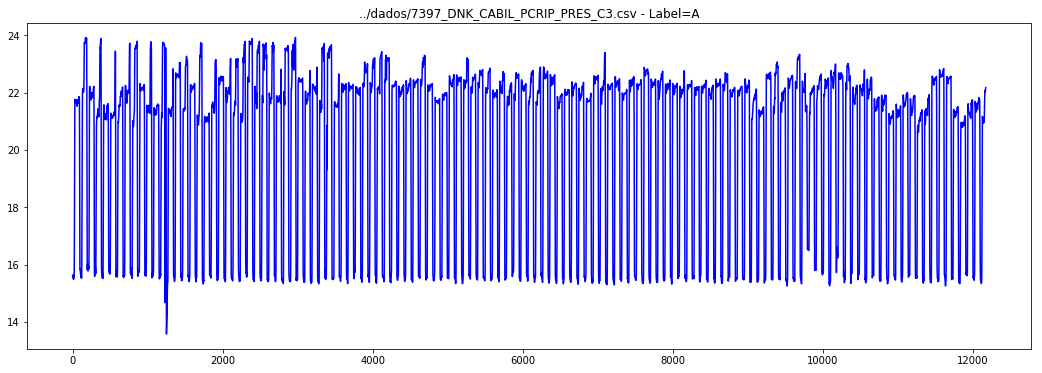

processando :  ../dados/dma1.1_flow.csv
0.40401606425702813


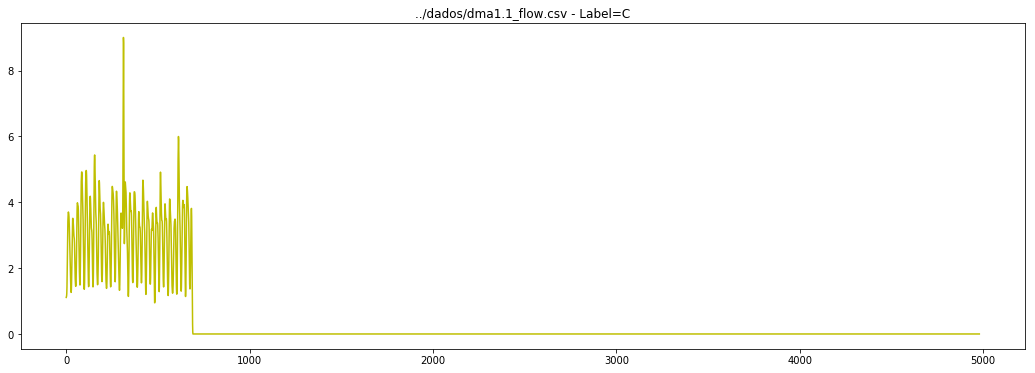

processando :  ../dados/dma1.1_pressure.csv
0.40401606425702813


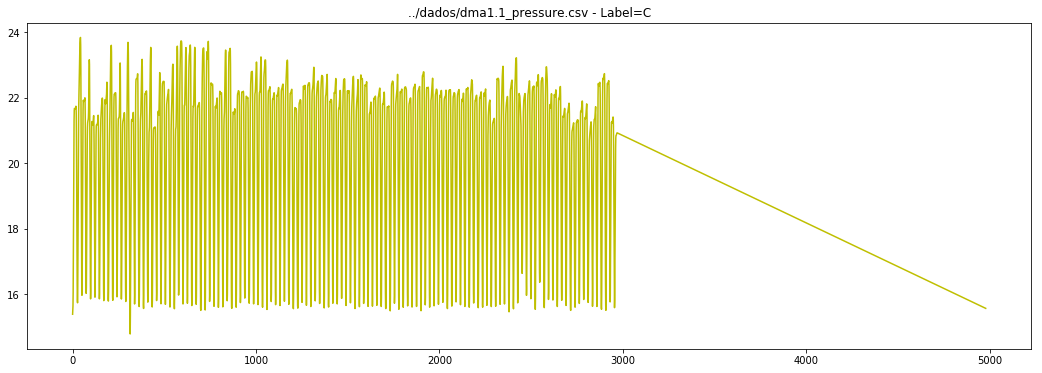

processando :  ../dados/dma1_flow.csv
0.05498821681068342


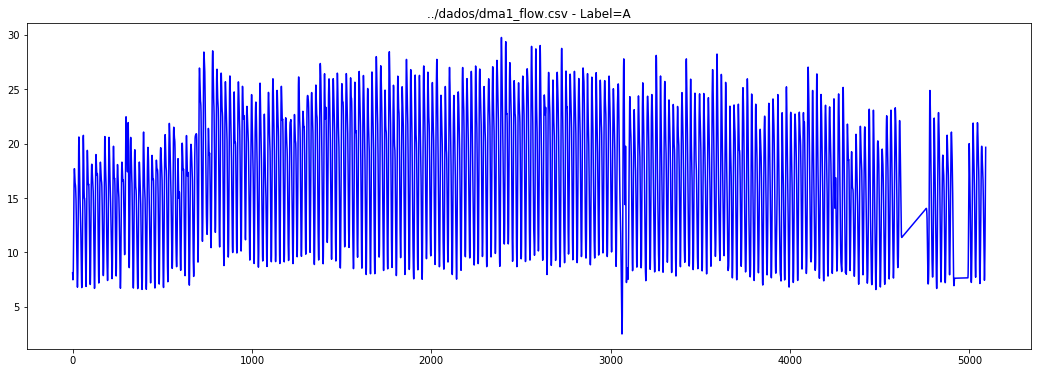

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC02.F_CV copy.csv
0.08842151648215721


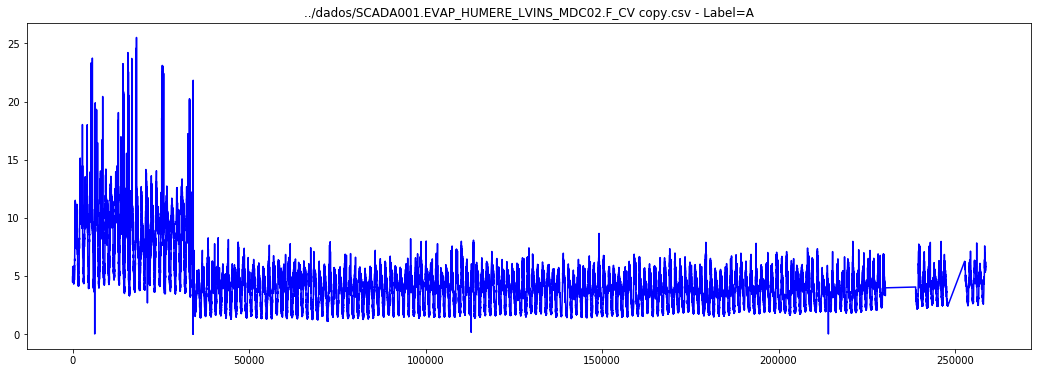

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC02.F_CV.csv
0.07217617180390794


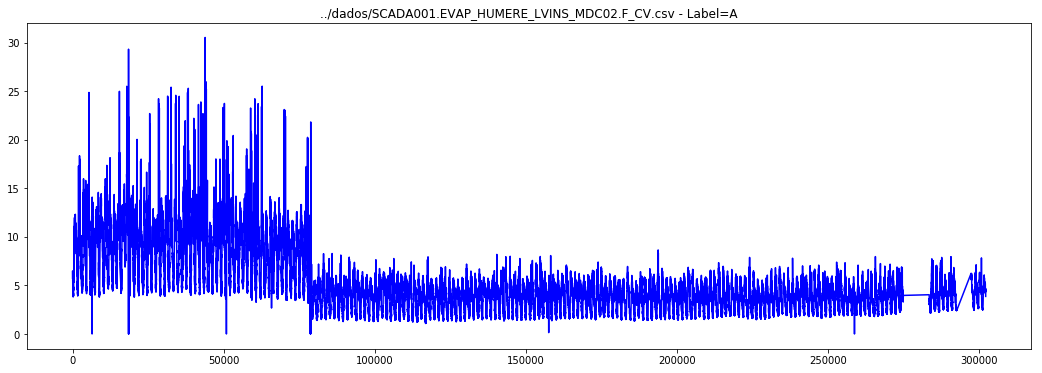

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC03.F_CV copy.csv
0.08843697816809945


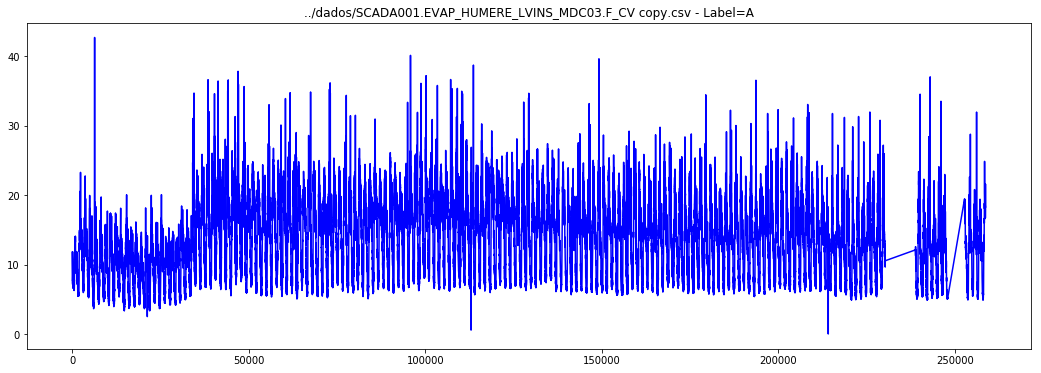

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC03.F_CV.csv
0.0721894078522857


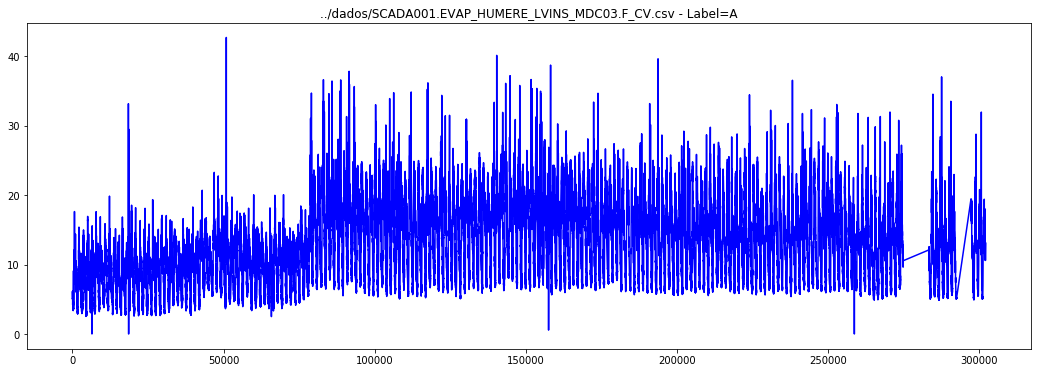

processando :  ../dados/SCADA001.EVAP_HUMERE_LVINS_MDC05.F_CV.csv
0.08845630527552724


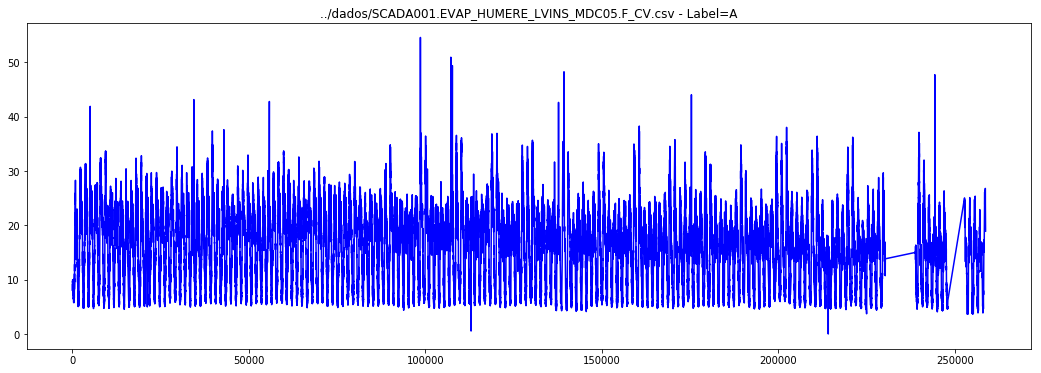

In [32]:
basefolder = '../dados/'
data = glob.glob(basefolder + '*.csv')

for filename in data:
    print("processando : ", filename)
    outputname = os.path.basename(filename) + '_filtered.csv'
    
    # loading dataset
    dataframe = pandas.read_csv(filename, engine='python', header=0)
    
    # column names
    columns = dataframe.keys()

    # converting to datetime
    dataframe[columns[0]] = pandas.to_datetime(dataframe[columns[0]])

    granularity     = get_granularity(dataframe)
    preprocessed_df, label = fill_missing_data(dataframe, granularity)
    preprocessed_df[columns[1]]     = smooth(preprocessed_df[columns[1]].values,window_len=10)
    plt.figure(figsize=(18,6))
    plt.title(filename+ " - Label="+str(label[0]))
    plt.plot(preprocessed_df.data.values, color=label[1])
    
    plt.show()
    
    

## Análise dos métodos de interpolação

processando :  ../dados/102048_GLE_CABIL_1P0F_EXP_PRES_C3.csv
0.43842393202188334


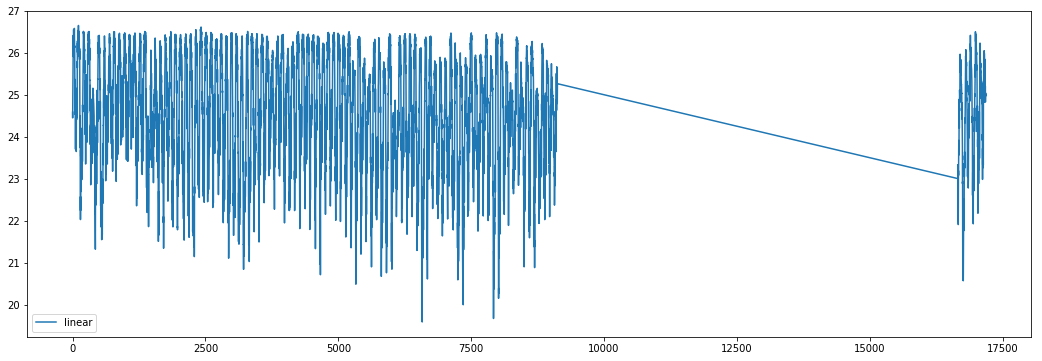

0.43842393202188334


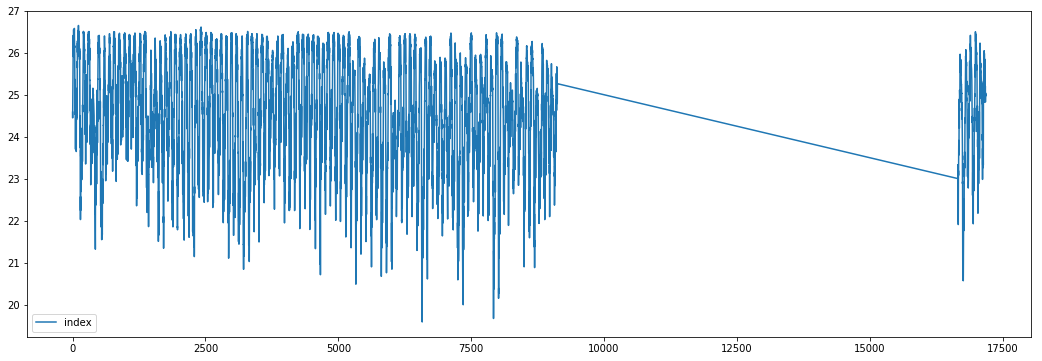

0.43842393202188334


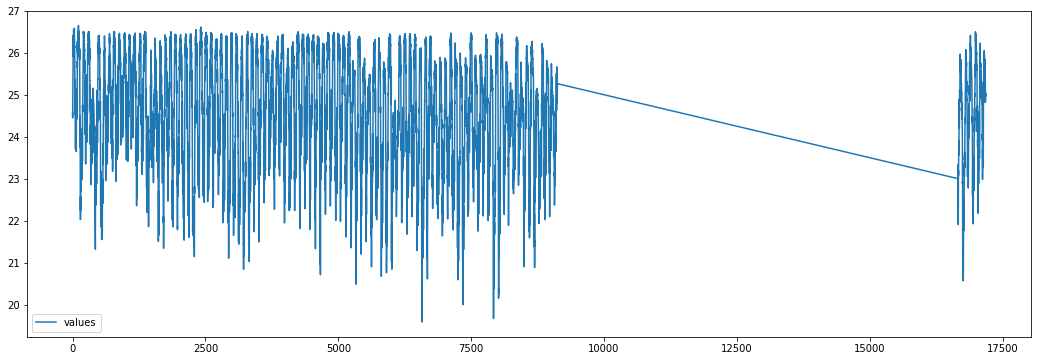

0.43842393202188334


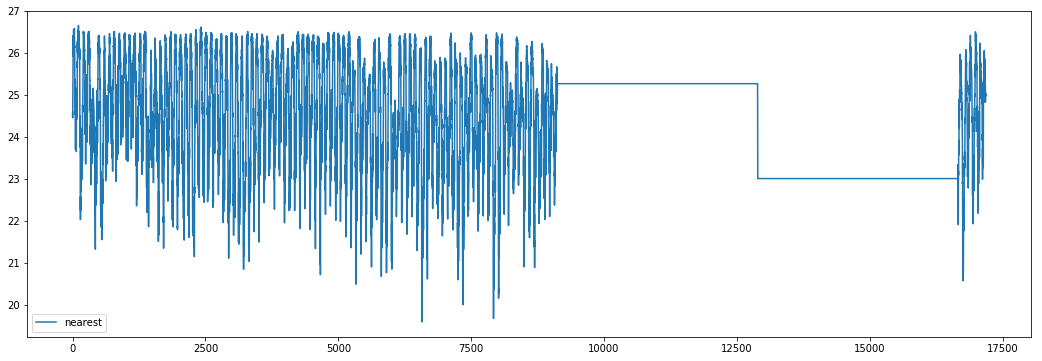

0.43842393202188334


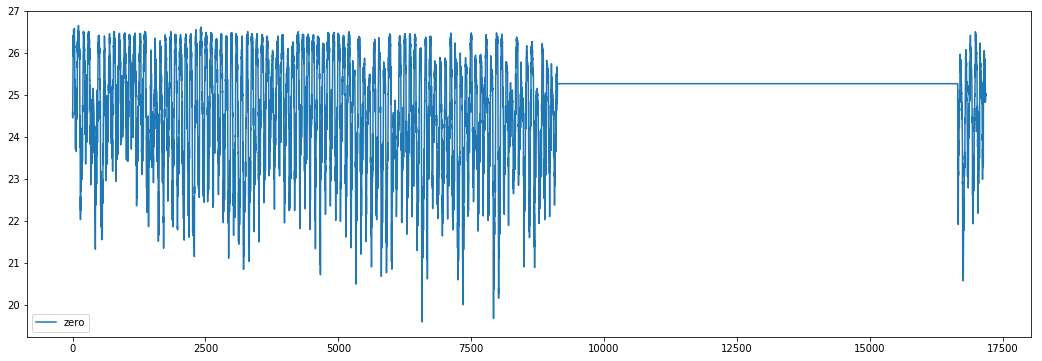

0.43842393202188334


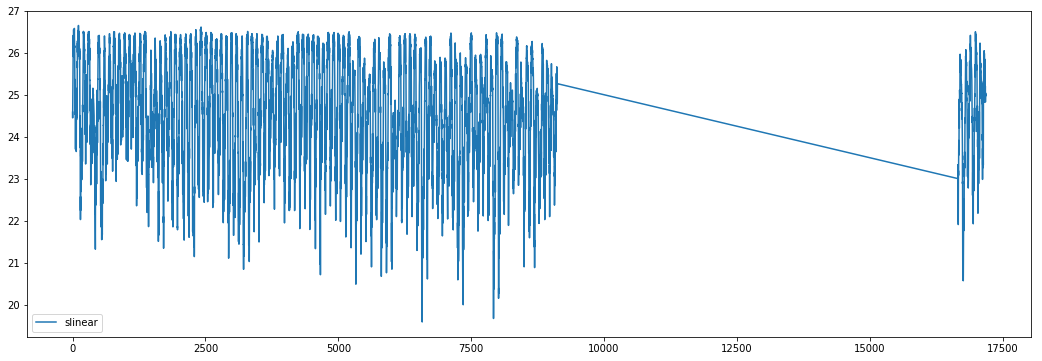

0.43842393202188334


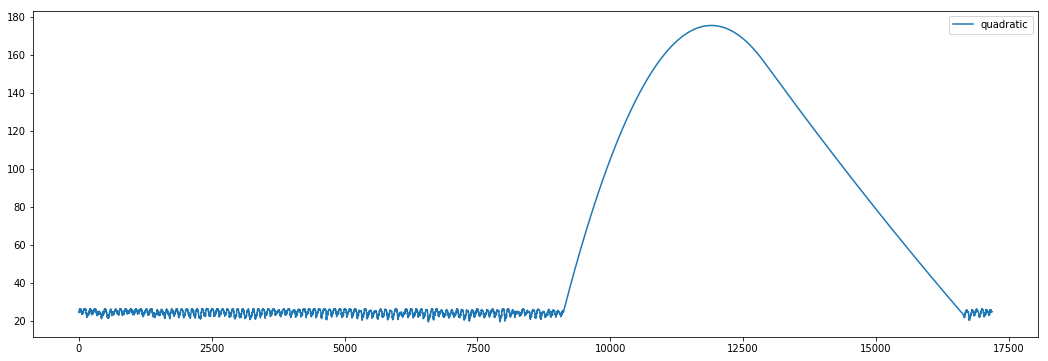

0.43842393202188334


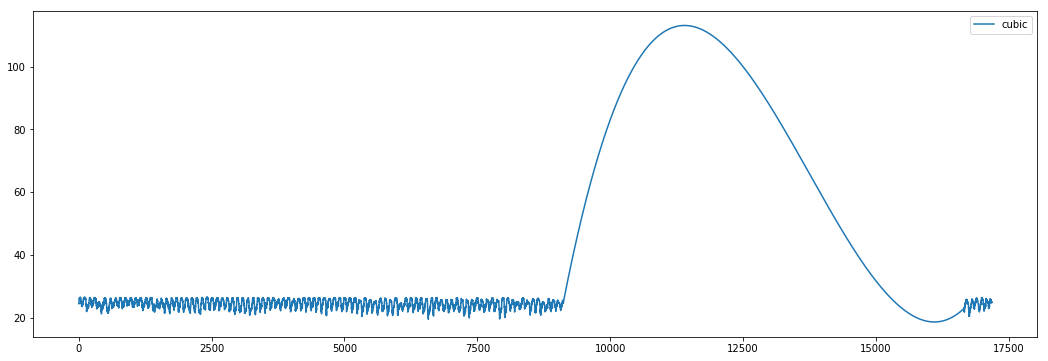

0.43842393202188334


/usr/local/lib/python3.6/site-packages/scipy/interpolate/polyint.py:511: RuntimeWarning: overflow encountered in multiply
  self.wi[:j] *= (self.xi[j]-self.xi[:j])
/usr/local/lib/python3.6/site-packages/scipy/interpolate/polyint.py:513: RuntimeWarning: divide by zero encountered in reciprocal
  self.wi **= -1
/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


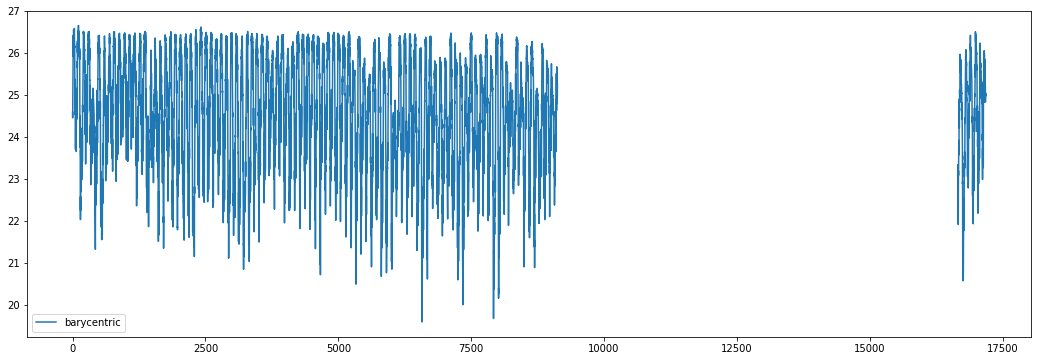

In [37]:
basefolder = '../dados/'
methods=['linear', 'index', 'values', 'nearest', 'zero', 
        'slinear', 'quadratic', 'cubic', 'barycentric']
data = glob.glob(basefolder + '*.csv')
filename = data[random.randint(0, len(data))]

print("processando : ", filename)

# loading dataset
dataframe = pandas.read_csv(filename, engine='python', header=0)

# column names
columns = dataframe.keys()

# converting to datetime
dataframe[columns[0]] = pandas.to_datetime(dataframe[columns[0]])

granularity     = get_granularity(dataframe)
for method in methods:
    preprocessed_df, score = fill_missing_data(dataframe, granularity, method)
    
    plt.figure(figsize=(18,6))
    plt.plot(preprocessed_df.data.values,label=method)
    plt.legend()
    
    plt.show()
    
